# Imports et setup technique

In [2]:
import pandas as pd
from IPython.display import display
idx = pd.IndexSlice
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
mcolorpalette = list(mcolor.TABLEAU_COLORS.values())
import matplotlib.dates as mdates
from pathlib import Path
persist_path = Path('..') / 'persist'
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from bokeh.io import output_notebook, show
output_notebook()
from bokeh.plotting import figure
from bokeh.models import CDSView, ColumnDataSource, GroupFilter, FactorRange, HoverTool
from bokeh.models.annotations import BoxAnnotation
from bokeh.layouts import row, column
from bokeh.models.formatters import NumeralTickFormatter

from functools import partial
from datetime import datetime, date
import sys
project_root = str(Path(sys.path[0]).parents[0].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)
from importlib import reload
from scripts.utils import compute_zscores, process_df, compute_distribution
import scripts.utils as utils

Loading BokehJS ...

# Chargement des données

## Données de base client

In [2]:
cltfields = {
             'client': 'object',
             'V': 'object',
             'groupecompte': 'object',
             'nom': 'object',
             'postalcode': 'object',
             'seg1': 'object',
             'seg2': 'object',
             'seg3': 'object',
             'seg4': 'object',
             'cat': 'object',
             'sscat': 'object',
#              'saiso': 'bool',
             'surcat': 'object',
#              'ecom': 'bool', 
             'sectact': 'object',
             'canal': 'object', 
             'orgacom': 'object', 
             'grpclt1': 'object',
             'grpclt2': 'object',
             'grpclt3': 'object',
             'grpclt4': 'object',
             'grpclt5': 'object',
             'agence': 'object', 
             'condexp': 'object', 
             'pricetype': 'object', 
             'relationtype': 'object',
             'pilcom': 'object',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

clt_fields2 = {
             'client': 'object',
             'V': 'category',
             'groupecompte': 'category',
             'nom': 'object',
             'postalcode': 'category',
             'seg1': 'category',
             'seg2': 'category',
             'seg3': 'category',
             'seg4': 'category',
             'cat': 'category',
             'sscat': 'category',
#              'saiso': 'bool',
             'surcat': 'category',
#              'ecom': 'bool', 
             'sectact': 'category',
             'canal': 'category', 
             'orgacom': 'category', 
             'grpclt1': 'category',
             'grpclt2': 'category',
             'grpclt3': 'category',
             'grpclt4': 'category',
             'grpclt5': 'category',
             'agence': 'category', 
             'condexp': 'category', 
             'pricetype': 'category', 
             'relationtype': 'category',
             'pilcom': 'category',
             'hier4': 'object',
             'hier3': 'object',
             'hier2': 'object',
             'hier1': 'object',
            }

filenames = [
    'ref_clt.csv',
    'ref_clt2.csv',
    'export2BRE_clt.csv',
    'exportcomp1ALO.csv',
]
paths = [Path('..') / 'data' / filename for filename in filenames]

df_clts = [
    pd.read_csv(path,
                sep=';',
                encoding='latin1', 
                dtype=cltfields,
                converters={'saiso': lambda x: True if x == 'YES' else False, 
                            'ecom': lambda x: True if x == 'X' else False},
                ) for path in paths
]

df_clt = pd.concat(df_clts, axis=0)
for field, dtype in clt_fields2.items(): 
    if field not in df_clt.columns:
        print(field)
df_clt = df_clt.astype(clt_fields2)
df_clt.sample(5)

client  V groupecompte                            nom postalcode seg1  \
12872  130346  A         ZCHN       AUB JEUNESSE LULTZHAUSEN       9666   Z3   
37401  220828  A         ZHIE  CHU TERRITOIRE SUD EST CHORUS      49000  NaN   
44751  274619  A         ZCRC      MFR CHEVANVEAUX H. PRESTA      17210   Z3   
17934  201741  A         ZLIV              MAGASIN  MAXXILOT      55000  NaN   
9389    54541  A         ZCLT  TRAIT LE CAVEAU DU PERE JULES      88400   Z3   

      seg2 seg3 seg4  cat  ... grpclt5  agence condexp  pricetype  \
12872   Z4   ZI   ZD   ZQ  ...     051    1LXB      ST         T2   
37401  NaN  NaN  NaN  NaN  ...     NaN     NaN     NaN        NaN   
44751   Z4   ZI   ZD   ZL  ...     051    1BDX      ST         T3   
17934  NaN  NaN  NaN  NaN  ...     051     NaN      ST        NaN   
9389    Z5   ZK   ZG   ZY  ...     051    1NAN      ST         T1   

      relationtype pilcom   hier4   hier3   hier2   hier1  
12872          NDI    RGL  132968  132967  132966  132965  
37401          NaN    NaN     NaN     NaN     NaN     NaN  
44751          NDI    NTL   10253   10254   10255   10256  
17934          NaN    NaN     NaN     NaN     NaN     NaN  
9389           NDI    RGL     NaN     NaN     NaN     NaN  

[5 rows x 31 columns]

In [3]:
# remove emppty client codes
df_clt = df_clt.loc[~df_clt.client.isna()]

# zero pad numeric clients codes
num_clt_mask = df_clt['client'].str.isnumeric()
df_clt.loc[num_clt_mask, 'client'] = df_clt.loc[num_clt_mask, 'client'].str.zfill(10)

#remove duplicated clients
print(f'Clients count before cleansing : {df_clt.client.count()}')
print(f"Duplicated clients before cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")
df_clt = df_clt.loc[~(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False) & df_clt.sectact.isna())]
print(f"Clients count after cleansing : {df_clt.client.count()}")
print(f"Duplicated clients after cleansing: {sum(df_clt.loc[:, ['client', 'orgacom']].duplicated(keep=False))}")

# set the index
df_clt.set_index(['orgacom', 'client'], inplace=True, drop=True)

Clients count before cleansing : 104640
Duplicated clients before cleansing: 4634
Clients count after cleansing : 102323
Duplicated clients after cleansing: 0


In [4]:
df_clt.sample(5)

V groupecompte                                  nom  \
orgacom client                                                            
1SOU    0000180422  A         ZCRC                           LES VAGUES   
        0000194959  A         ZCLT  ACCUEIL FRERE JEAN MAISON DE RETRAI   
2BRE    0000082173  A         ZCLT               API AT MDR LES TAMARIS   
1SOU    0000256476  A         ZCLT                   SNACK DES CASERNES   
        0000189966  A         ZCLT                      LA BIBLIOTHEQUE   

                   postalcode seg1 seg2 seg3 seg4 cat sscat  ...  grpclt5  \
orgacom client                                               ...            
1SOU    0000180422      33120   Z3   Z5   ZK   ZG  ZT    ZK  ...      051   
        0000194959      65330   Z3   Z4   ZI   ZD  ZN   Z19  ...      051   
2BRE    0000082173      22750   Z3   Z4   ZJ   ZF  ZN   Z19  ...      L51   
1SOU    0000256476      40510   Z3   Z5   ZK   ZG  ZW    ZT  ...      051   
        0000189966      87000   Z3   Z5   ZK   ZG  ZS    ZK  ...      051   

                   agence  condexp pricetype relationtype pilcom  hier4  \
orgacom client                                                            
1SOU    0000180422   1BDX       ST        T3          NDI    RGL    NaN   
        0000194959   1PAU       ST        T3          NDI    NTL  10492   
2BRE    0000082173   2COT       ST        T1          DIR    NTL  10506   
1SOU    0000256476   1BAY       ST        T2          NDI    RGL    NaN   
        0000189966   1LIM       ST        T2          NDI    RGL    NaN   

                    hier3  hier2  hier1  
orgacom client                           
1SOU    0000180422    NaN    NaN    NaN  
        0000194959  10493  10494  10495  
2BRE    0000082173  10509  10514  10528  
1SOU    0000256476    NaN    NaN    NaN  
        0000189966    NaN    NaN    NaN  

[5 rows x 29 columns]

In [5]:
if sum(df_clt.index.duplicated()):
    raise RuntimeError('Something went wrong on the client dataframe! Some indices are duplicated!')

In [6]:
print(*df_clt.groupecompte.unique())

ZCLT ZFAC ZCHN ZCFR ZPER ZLIV ZCRC ZHIE ZCOL ZREG ZCTR ZCFE ZCAC ZCFG ZCPP ZCRI ZCRM ZGPE 0100 ZCPD ZCAB


Libellés des segments clients :

In [7]:
path = Path('..') / 'data' / 'libelles_segments.csv'
lib_seg = pd.read_csv(path,
                      sep=';',
                      encoding='latin1',
                      header=None,
                      names=['level', 'code', 'designation'],
                      index_col=['level', 'code']
                     )
lib_seg

designation
level code                     
1     Z1           Distribution
      Z3                    RHD
      Z4                 Divers
2     Z0      Autres clientèles
      Z1                    GMS
...                         ...
6     ZI    Police Pomp Gendarm
      ZJ    Gastro -semi gastro
      ZK          Moyenne gamme
      ZL             Economique
      ZM    Petit déj. exclusif

[136 rows x 1 columns]

## Historiques de vente

In [8]:
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES.csv'
# path = Path('..') / 'data' / 'EXTRACT_LIGNES_VENTES_v2.csv'
path_list = [Path('..') / 'data' / filename for filename in ['EXTRACT_LIGNES_VENTES_V3.csv',
                                                             'EXTRACTION_2BRE.csv']]
fields = {'orgacom': pd.CategoricalDtype(['1SOU', '1ALO', '1LRO', '2BRE'], ordered=True),
          'month': 'category',
          'week': 'category',
          'date': 'object',
          'pricetype': 'category',
          'client': 'object',
          'doctype': 'category',
          'origin': pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB', '#', 'SCHR', 'TELE',
                                         'MUEN', 'FRN', 'DFUE'], ordered=True),
          'salesgroup': 'category',
          'material': 'object',
          'brutrevenue': 'float',
          'brutrevcur': 'category', 
          'netrevenue': 'float', 
          'netrevcur': 'category',
          'weight': 'float',
          'weightunit': 'category',
          'margin': 'float', 
          'margincur': 'category', 
          'marginperkg': 'float',
         }

In [9]:
data = [pd.read_csv(path,
                   sep=';',
                   header=None,
                   names=list(fields.keys()),      
                   dtype=fields, 
                   parse_dates=['date'],
                  ) for path in path_list]
data = pd.concat(data, axis=0)
data.sample(5)

orgacom   month    week       date pricetype      client doctype  \
3059855     1ALO  201710  201742 2017-10-22      ZTCE  0000023507    ZC10   
30464326    1SOU  202006  202026 2020-06-22      ZTCE  0000236638    ZC10   
10482482    1SOU  201806  201825 2018-06-24      ZTCE  0000162148    ZC10   
25280948    1ALO  201911  201946 2019-11-17      ZTCE  0000021016    ZC10   
8710261     1SOU  201804  201817 2018-04-26      ZTCE  0000086929    ZC10   

         origin salesgroup            material  brutrevenue brutrevcur  \
3059855     EDI        H30  000000000000009017         0.00        EUR   
30464326     TV        782  000000000000007305        34.70        EUR   
10482482    EDI        801  000000000000039120         0.00        EUR   
25280948    EDI        595  000000000000008770         0.00        EUR   
8710261     EDI        802  000000000000162597        36.65        EUR   

          netrevenue netrevcur  weight weightunit  margin margincur  \
3059855        -0.01       EUR   0.000         KG   -0.01       EUR   
30464326       24.98       EUR   6.218         KG    3.30       EUR   
10482482        0.25       EUR   0.000         KG    0.25       EUR   
25280948       -0.01       EUR   0.000         KG   -0.01       EUR   
8710261        26.48       EUR   5.000         KG   -3.58       EUR   

          marginperkg  
3059855          0.00  
30464326         0.53  
10482482         0.00  
25280948         0.00  
8710261         -0.72

## Filtres sur les données
### Filtre sur les types de documents
Définition des types de poste valides et invalides.
PAR CONTRE, on ne filtre plus les documents de type avoir !

In [10]:
valid_doctypes = ['ZC01', 'ZC02', 'ZC10']
invalid_doctypes = ['ZR01', 'ZR02', 'ZA01', 'ZA02', 'ZA03', 'ZA04', 'ZC20']
doctypes = valid_doctypes + invalid_doctypes

In [11]:
if len(data.loc[~data.doctype.isin(doctypes)]) > 0:
    raise RuntimeError(f'An unexpected doctype has been encountered: '
                       f'{data.loc[~data.doctype.isin(doctypes), "doctype"].iloc[0]}!')

In [12]:
order_doctype_mask = data.doctype.isin(valid_doctypes)

## Nettoyage des poids / CA à zéro
On contrôle d'abord qu'il n'y a pas de ligne de commande avec un poids à zéro mais un CA associé

In [13]:
if len(data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0)]) > 0:
    print('Some sales have no weight but have brut revenue!')
data.loc[order_doctype_mask & (data.weight == 0) & (data.brutrevenue != 0), 'material'].unique()

Some sales have no weight but have brut revenue!


array(['FL ACCOR', 'FL39860', 'FL66446', 'FC42378', '000000000000156486',
       'FC34504', 'FC34502', 'FC34503'], dtype=object)

On contrôle que le CA brut des commandes est toujours positif.

In [14]:
if len(data.loc[order_doctype_mask & (data.brutrevenue < 0)]) > 0: 
    raise RuntimeError('Some sales have negative brut revenue!')

## Calcul des indicateurs manquants

In [15]:
data['purchcost'] = data.brutrevenue - data.margin
data['purchcostperkg'] = data.purchcost / data.weight
data['PMVK'] = data.brutrevenue / data.weight
data['marginpercent'] = (data.margin / data.brutrevenue).replace({np.inf: np.nan, -np.inf: np.nan})

## Définition des formats des indicateurs

In [16]:
formats = utils.formats

## Nettoyage des avoirs
### Constat d'erreurs et corrections sur les prix
Il apparaît que certaines erreurs sur les prix qui faussent l'analyse ont eu un impact fort sur les indicateurs :

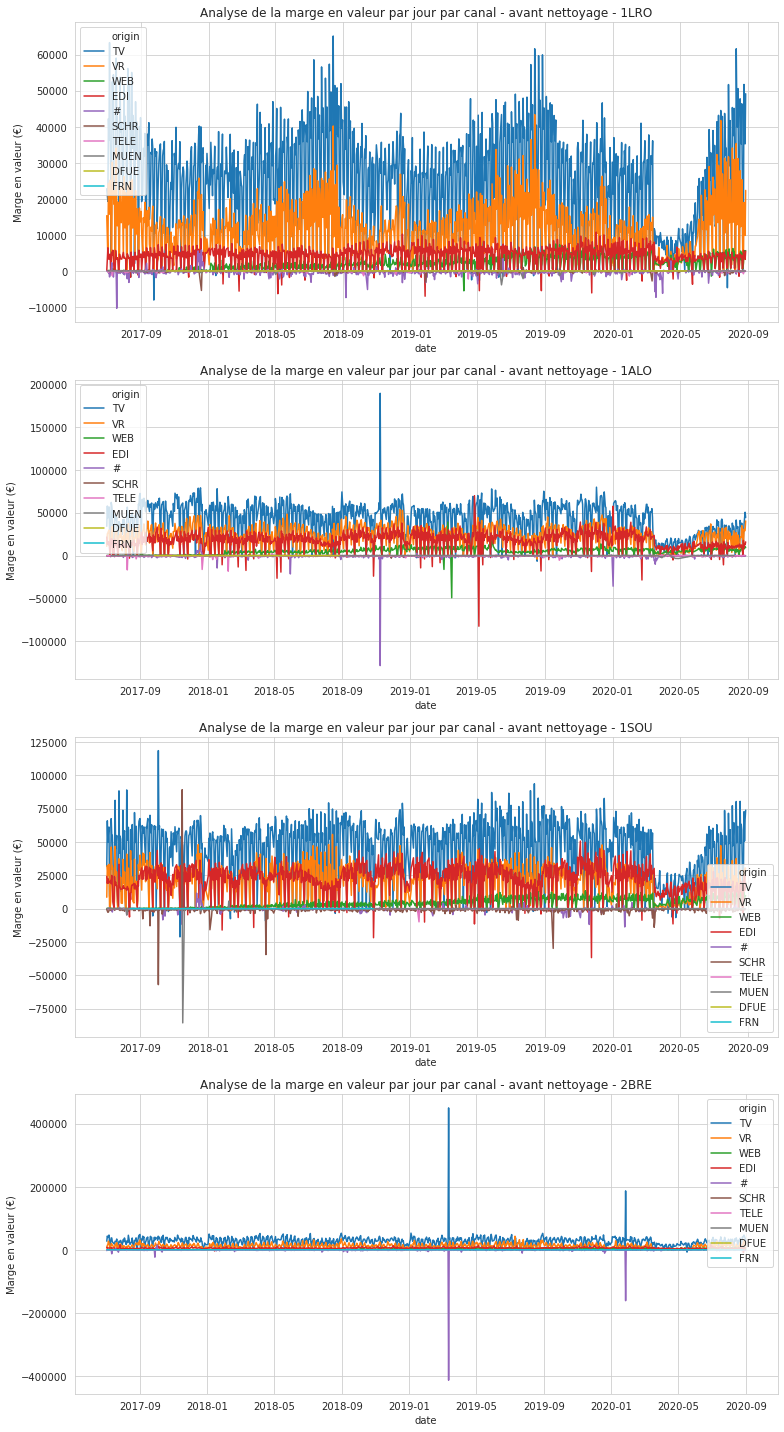

In [17]:
mult_origins_order = ['TV', 'VR', 'WEB', 'EDI', '#', 'SCHR', 'TELE', 'MUEN', 'DFUE', 'FRN']

nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (11, 5 * nrows), nrows=nrows)
orgacoms = data.orgacom.unique().tolist()
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in orgacoms]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - avant nettoyage - {orgacoms[i]}')
    axs[i].set_ylabel('Marge en valeur (€)')
fig.tight_layout()

On voit 3 gros pics négatifs qui sont des corrections d'erreur sur les prix, mais pas affectés au canal correspondant.

### Calcul d'une table des avoirs, aggrégée

In [18]:
myfields = ['orgacom',
            'doctype',
            'date',
            'origin',
            'material',
            'client',
            'brutrevenue',
            'weight',
            'PMVK',
            'marginperkg',
            'margin',
            'purchcost',
            'purchcostperkg']

In [19]:
%%time
dfs = []
for suc in data.orgacom.unique():
    print(f'Début du traitement pour {suc}')
    to_process = data.loc[data.orgacom == suc]
    data = data.loc[data.orgacom != suc]
    dfs.append(process_df(to_process))

Début du traitement pour 1LRO
Evolution des indicateurs pendant le traitement : 
margin        -9.685755e-08
brutrevenue   -2.384186e-07
weight        -1.490116e-08
dtype: float64
Début du traitement pour 1ALO
Evolution des indicateurs pendant le traitement : 
margin        -7.450581e-07
brutrevenue    1.192093e-07
weight         7.450581e-08
dtype: float64
Début du traitement pour 1SOU
Evolution des indicateurs pendant le traitement : 
margin        -1.490116e-08
brutrevenue   -1.549721e-06
weight         1.341105e-07
dtype: float64
Début du traitement pour 2BRE
Evolution des indicateurs pendant le traitement : 
margin         2.086163e-07
brutrevenue   -1.788139e-07
weight         4.470348e-08
dtype: float64
CPU times: user 4min 46s, sys: 38.3 s, total: 5min 24s
Wall time: 5min 24s


In [20]:
data = pd.concat(dfs, axis=0)
del(dfs)
data.sample(10)

orgacom   month    week       date pricetype      client doctype  \
3486518     1SOU  201804  201817 2018-04-24      ZTCN  0000189905    ZC10   
45704       1SOU  201707  201727 2017-07-05       ZTG  0000157638    ZC10   
1031359     1SOU  201709  201738 2017-09-24      ZTCE  0000070246    ZC10   
3092838     2BRE  201810  201842 2018-10-15      ZTCE  0000188832    ZC10   
5854190     1ALO  201811  201848 2018-11-26       ZTM  0000025941    ZC10   
4726541     1ALO  201808  201834 2018-08-24      ZTCE  0000211919    ZC10   
12068680    1SOU  202004  202016 2020-04-15      ZTCE  0000118840    ZC10   
10586977    1ALO  202001  202003 2020-01-14      ZTCR      SL001P    ZC10   
3962531     2BRE  201902  201909 2019-02-28      ZTCE  0000072751    ZC10   
2402763     1SOU  201801  201803 2018-01-18      ZTCN  0000219234    ZC10   

         origin salesgroup            material  ... margincur  marginperkg  \
3486518      TV        785  000000000000138682  ...       EUR         0.55   
45704        TV        916  000000000000026352  ...       EUR         1.92   
1031359     EDI        802  000000000000047123  ...       EUR         0.00   
3092838      TV        K09  000000000000002814  ...       EUR         0.59   
5854190      VR        642  000000000000031307  ...       EUR         2.88   
4726541     EDI        595  000000000000087484  ...       EUR         0.20   
12068680    EDI        817  000000000000029904  ...       EUR         0.15   
10586977     VR          #  000000000000044354  ...       EUR         0.56   
3962531      TV        A02  000000000000043143  ...       EUR         2.02   
2402763      TV        K99  000000000000054752  ...       EUR         0.62   

         purchcost purchcostperkg      PMVK  marginpercent  _duplicated  \
3486518      10.78       3.266667  3.818182       0.144444        False   
45704         2.99       1.196000  3.112000       0.615681        False   
1031359       0.40            inf       NaN            NaN        False   
3092838      15.84       3.300000  3.889583       0.151580        False   
5854190     183.25       6.108333  8.990000       0.320541         True   
4726541      14.33       1.146400  1.343200       0.146516        False   
12068680     25.61       0.853667  1.005000       0.150580        False   
10586977     25.59       8.978947  9.536842       0.058499         True   
3962531       7.30       7.300000  9.320000       0.216738        False   
2402763       3.82       4.244444  4.866667       0.127854        False   

          margin  brutrevenue  weight  
3486518     1.82        12.60    3.30  
45704       4.79         7.78    2.50  
1031359    -0.40         0.00    0.00  
3092838     2.83        18.67    4.80  
5854190    86.45       269.70   30.00  
4726541     2.46        16.79   12.50  
12068680    4.54        30.15   30.00  
10586977    1.59        27.18    2.85  
3962531     2.02         9.32    1.00  
2402763     0.56         4.38    0.90  

[10 rows x 24 columns]

On peut plotter les indicateurs après nettoyage :

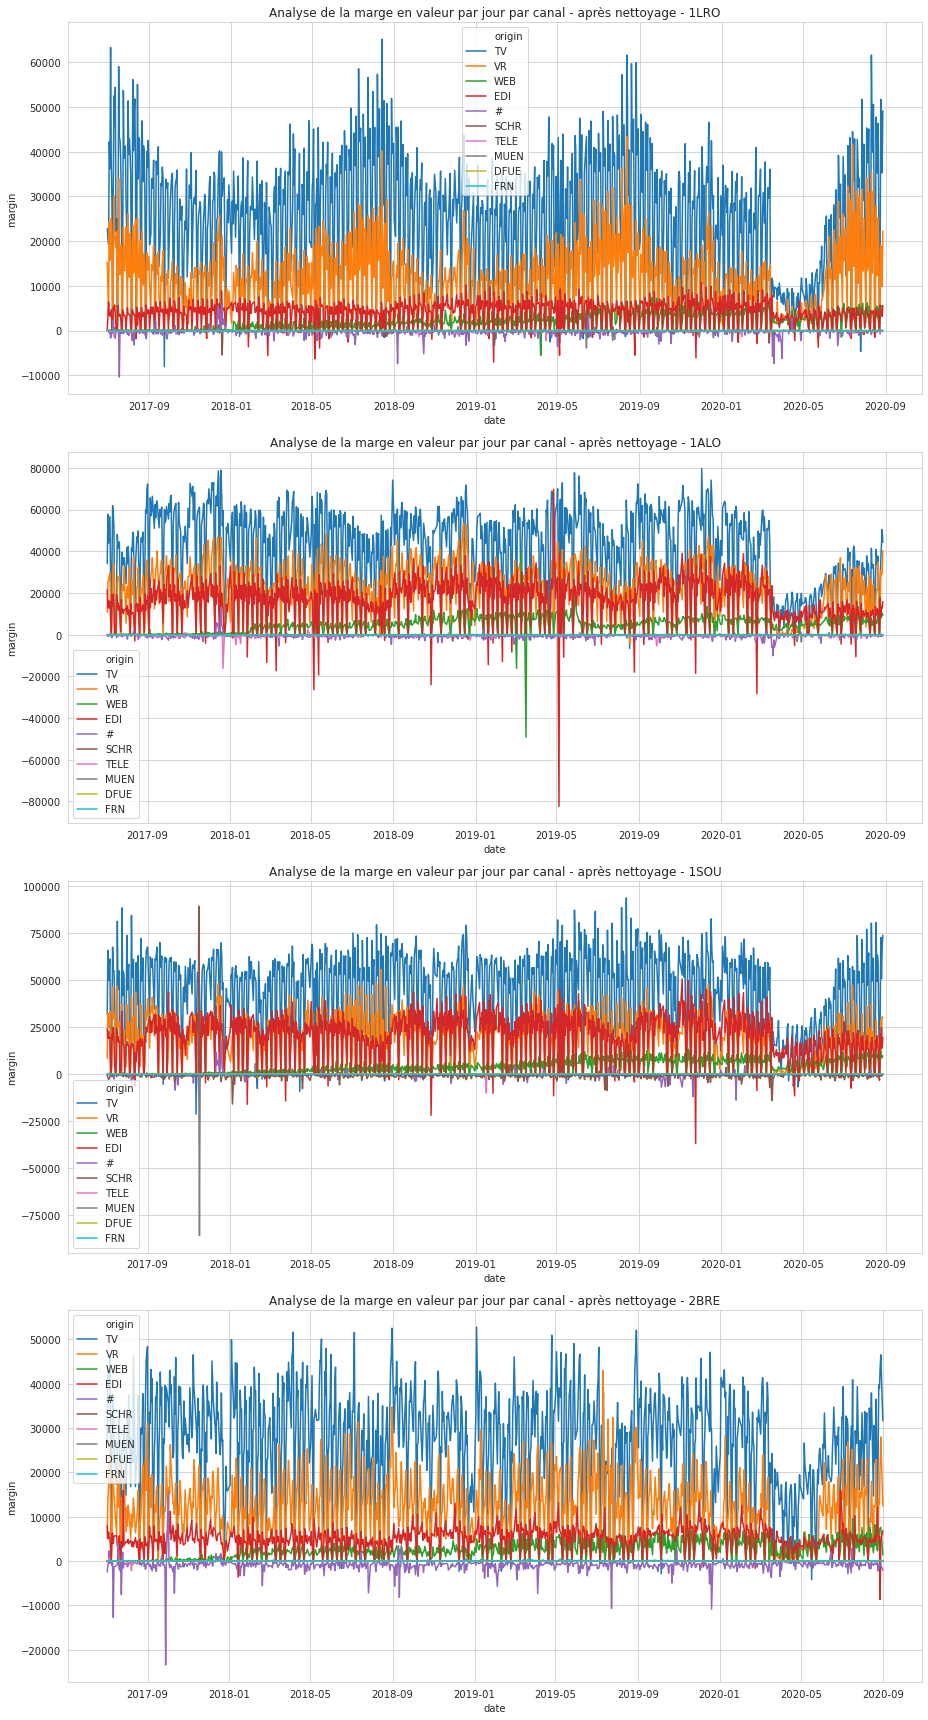

In [21]:
nrows = len(data.orgacom.unique())
fig, axs = plt.subplots(figsize = (13, 6 * nrows), nrows=nrows)
data_to_plot = [(
    data.loc[data.orgacom == orgacom]
        .groupby(['date', 'origin'])['margin']
        .sum()
        .unstack('origin')
        .fillna(0.)
        .rolling(1, win_type='triang')
        .mean()
        .stack('origin')
        .rename('margin')
        .reset_index()
) for orgacom in data.orgacom.unique()]

for i, data_ in enumerate(data_to_plot):
    sns.lineplot(data=data_,
                 x='date',
                 y='margin',
                 hue='origin',
                 hue_order=mult_origins_order,
                 ax=axs[i])
    axs[i].set_title(f'Analyse de la marge en valeur par jour par canal - après nettoyage - {orgacoms[i]}')
fig.tight_layout()

In [116]:
data.to_pickle(persist_path / 'data.pkl')

## Affichage des indicateurs par succursale et canal

In [22]:
indicator_map = {
    'Marge (€)': 'margin',
    'CA brut (€)': 'brutrevenue',
    'Tonnage (kg)': 'weight',
}

CPU times: user 23.8 s, sys: 3.62 s, total: 27.4 s
Wall time: 27.2 s


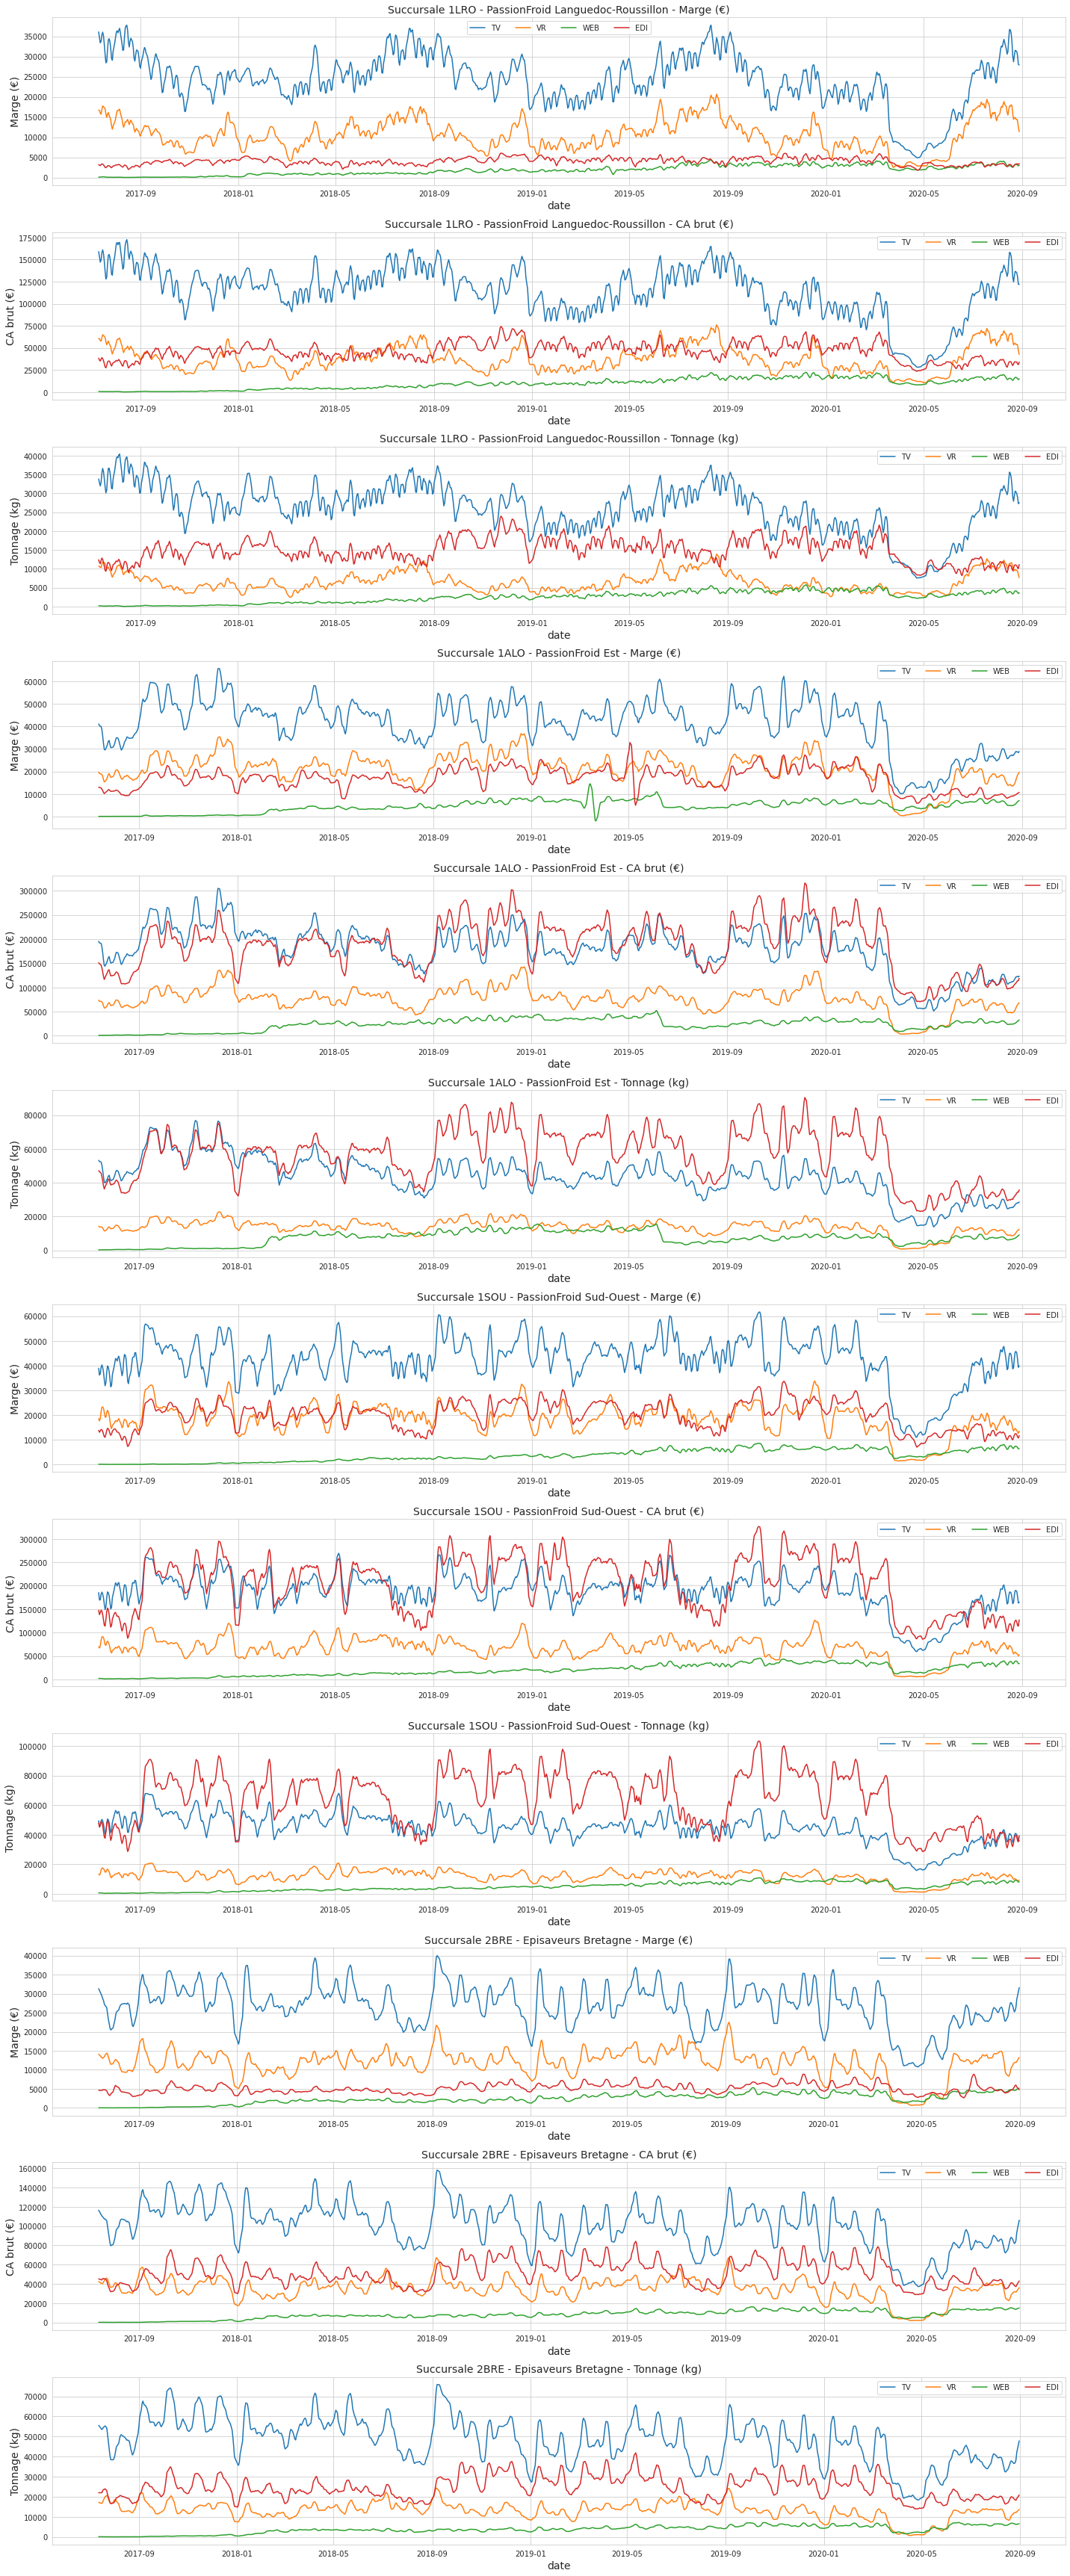

In [23]:
%%time
SV = data['orgacom'].unique()
indicators = ['weight', 'brutrevenue', 'margin']
roll_width = 10
win_type = 'triang'
fig, axs = plt.subplots(figsize=(20, 4 * len(SV)* len(indicator_map)),
                        nrows=len(SV) * len(indicator_map),
#                         squeeze=False,
                       )

for i, suc in enumerate(SV):
    for j, indicator in enumerate(indicator_map):
        
        data_to_plot = (
            data.loc[(data.orgacom == suc) & data.origin.isin(['TV', 'VR', 'WEB', 'EDI'])]
                .groupby(['date', 'origin'], observed=True)[indicator_map[indicator]]
                .sum()
                .unstack('origin')
                .fillna(0.)
                .rolling(roll_width, win_type=win_type)
                .mean()
                .stack('origin')
                .rename(indicator)
                .sort_index()
                .reset_index())
        sns.lineplot(data=data_to_plot,
                     x='date',
                     y=indicator,
                     hue='origin',
                     hue_order=mult_origins_order[:4],                     
                     ax=axs[i * len(indicator_map) + j])
        handles, labels = axs[i * len(indicator_map) + j].get_legend_handles_labels()
        handles = handles[1:]
        labels = labels[1:]
        axs[i * len(indicator_map) + j].legend(handles, labels, ncol=4, )
        axs[i * len(indicator_map) + j].set_title(f'Succursale {utils.lib(suc)} - {indicator}', fontsize=14)
        axs[i * len(indicator_map) + j].xaxis.label.set_fontsize(14)
        axs[i * len(indicator_map) + j].yaxis.label.set_fontsize(14)
        
fig.tight_layout()

## Filtration des canaux "exotiques"

In [24]:
origin2_cat = pd.CategoricalDtype(['TV', 'VR', 'EDI', 'WEB'], ordered=True)
data['origin2'] = data.origin.astype(origin2_cat)

## Calcul du canal majoritaire par jour

In [25]:
aggfuncs = {
    'margin': 'sum', 
    'brutrevenue': 'sum',
    'weight': 'sum',
    'origin2': 'size',
}
orders = (
    data.loc[(data.doctype == 'ZC10') & (data.weight > 0.) & (data.brutrevenue > 0.)]
        .groupby(['orgacom', 'date', 'client', 'origin2'], observed=True)
        .agg(aggfuncs)
        .rename({'origin2': 'linecount'}, axis=1)
)
print(f'{len(orders)} records in order dataframe before canal deduplication')
orders

2751677 records in order dataframe before canal deduplication


margin  brutrevenue   weight  linecount
orgacom date       client     origin2                                         
1SOU    2017-07-03 0000065940 TV        31.16        84.01    5.501          9
                   0000065945 TV         6.02        23.69    3.734          2
                   0000065975 TV        25.15        97.40   13.718          1
                   0000065998 TV         4.12         8.56    1.000          1
                   0000066014 TV        17.89        48.30    5.000          1
...                                       ...          ...      ...        ...
2BRE    2020-08-31 0000285226 VR         1.38        10.16   10.000          2
                   SL001W     TV        89.34       555.25  180.000          4
                   SL0041     TV        28.42      1470.00    7.200          1
                   SL0075     TV        12.76        95.03   15.615         11
                   SL009N     TV        10.51        75.03   40.500          1

[2751677 rows x 4 columns]

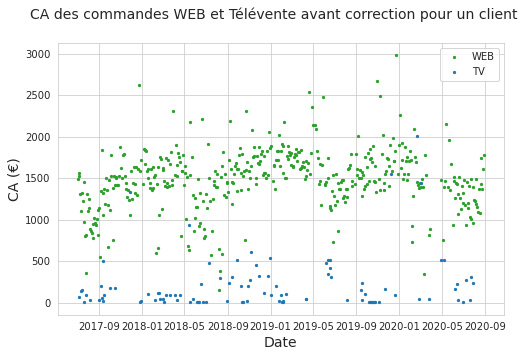

In [26]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


On considère le canal de la commande comme étant le canal qui représente le plus en poids pour un jour donné.

In [27]:
major_canal = orders['weight'].unstack(fill_value=0.).idxmax(axis=1).rename('origin2')
major_canal

orgacom  date        client    
1SOU     2017-07-03  0000065940     TV
                     0000065945     TV
                     0000065975     TV
                     0000065998     TV
                     0000066014     TV
                                  ... 
2BRE     2020-08-31  0000282373    EDI
                     0000283953    EDI
                     0000284089     TV
                     0000284540     TV
                     0000284735     VR
Name: origin2, Length: 2444326, dtype: object

In [28]:
orders = orders.groupby(level=[0, 1, 2], observed=True).sum().join(major_canal)
del(major_canal)
order_count = len(orders)
print(f'{order_count} records in order dataframe after canal deduplication')
orders

2444326 records in order dataframe after canal deduplication


margin  brutrevenue   weight  linecount origin2
orgacom date       client                                                     
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9      TV
                   0000065945    6.02        23.69    3.734          2      TV
                   0000065975   25.15        97.40   13.718          1      TV
                   0000065998    4.12         8.56    1.000          1      TV
                   0000066014   17.89        48.30    5.000          1      TV
...                               ...          ...      ...        ...     ...
2BRE    2020-08-31 0000285226  103.91       433.56   80.455         24      TV
                   SL001W       89.34       555.25  180.000          4      TV
                   SL0041       28.42      1470.00    7.200          1      TV
                   SL0075       12.76        95.03   15.615         11      TV
                   SL009N       10.51        75.03   40.500          1      TV

[2444326 rows x 5 columns]

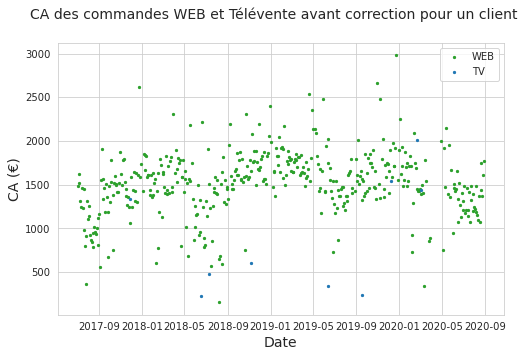

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
temp = (orders.reset_index()
              .set_index(['orgacom', 'date', 'client', 'origin2'])
              .loc[idx[:, :, '0000200584', :]]
              .reset_index()
       )
ax.scatter(x=temp.loc[temp.origin2 == 'WEB'].date,
           y=temp.loc[temp.origin2 == 'WEB'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[2],
           s=5.,
           label='WEB')
ax.scatter(x=temp.loc[temp.origin2 == 'TV'].date,
           y=temp.loc[temp.origin2 == 'TV'].brutrevenue,
           color=list(mcolor.TABLEAU_COLORS.values())[0],
           s=5.,
           label='TV')
del(temp)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('CA (€)', fontsize=14)
fig.suptitle('CA des commandes WEB et Télévente avant correction pour un client', fontsize=14)
ax.legend()


In [117]:
orders.to_pickle(persist_path / 'orders.pkl')

## Ajout de la segmentation et de la hiérarchie

On ajoute quelques données du dataset client.

In [30]:
clt_fields = ['seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat', 'hier4']
for field in clt_fields:
    try:
        orders = orders.drop(field)
    except: 
        pass
orders = orders.merge(df_clt.loc[:, clt_fields], left_on=['orgacom', 'client'], right_index=True, validate='m:1')
if len(orders) != order_count:
    raise RuntimeError('Something went wrong when merging orders with client master data!')

In [31]:
orders

margin  brutrevenue   weight  linecount  \
orgacom date       client                                                
1SOU    2017-07-03 0000065940   31.16        84.01    5.501          9   
        2017-08-28 0000065940   44.36       105.93    8.048         10   
        2017-09-08 0000065940   17.60        40.35    3.000          2   
        2017-09-15 0000065940  100.12       236.77   20.312          3   
        2017-09-25 0000065940   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    2020-08-31 0000282373  177.42      1401.58  488.036         88   
                   0000283953   43.79       421.67  564.980         28   
                   0000284089   89.39       186.75   90.200         12   
                   0000284540  262.04      1252.07  639.326         97   
                   0000284735  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat sscat  hier4  
orgacom date       client                                                   
1SOU    2017-07-03 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-08-28 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-08 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-15 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
        2017-09-25 0000065940      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  
...                               ...  ...  ...  ...  ...  ..   ...    ...  
2BRE    2020-08-31 0000282373     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705  
                   0000283953     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506  
                   0000284089      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN  
                   0000284540      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432  
                   0000284735      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN  

[2444326 rows x 12 columns]

## Calcul des indicateurs composites

In [32]:
composite_indicators_dict = utils.composite_indicators_dict

for indicator, components in composite_indicators_dict.items():
    try:
        orders[indicator] = orders[components[0]] / orders[components[1]]
    except KeyError:
        pass

orders = orders.reset_index()
orders

orgacom       date      client  margin  brutrevenue   weight  \
0          1SOU 2017-07-03  0000065940   31.16        84.01    5.501   
1          1SOU 2017-08-28  0000065940   44.36       105.93    8.048   
2          1SOU 2017-09-08  0000065940   17.60        40.35    3.000   
3          1SOU 2017-09-15  0000065940  100.12       236.77   20.312   
4          1SOU 2017-09-25  0000065940   96.04       253.99   40.338   
...         ...        ...         ...     ...          ...      ...   
2444321    2BRE 2020-08-31  0000282373  177.42      1401.58  488.036   
2444322    2BRE 2020-08-31  0000283953   43.79       421.67  564.980   
2444323    2BRE 2020-08-31  0000284089   89.39       186.75   90.200   
2444324    2BRE 2020-08-31  0000284540  262.04      1252.07  639.326   
2444325    2BRE 2020-08-31  0000284735  319.24       782.56  235.236   

         linecount origin2 seg1 seg2 seg3 seg4 cat sscat  hier4       PMVK  \
0                9      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  15.271769   
1               10      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.162276   
2                2      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  13.450000   
3                3      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897  11.656656   
4                5      TV   Z3   Z4   ZI   ZB  ZL   Z13  10897   6.296544   
...            ...     ...  ...  ...  ...  ...  ..   ...    ...        ...   
2444321         88     EDI   Z3   Z4   ZJ   ZF  ZP    ZA  10705   2.871878   
2444322         28     EDI   Z3   Z4   ZJ   ZF  ZN   Z19  10506   0.746345   
2444323         12      TV   Z3   Z5   ZK   ZG  ZU   Z43    NaN   2.070399   
2444324         97      TV   Z3   Z4   ZJ   ZF  ZP    ZA  10432   1.958422   
2444325         58      VR   Z3   Z5   ZK   ZG  ZU    ZN    NaN   3.326702   

         marginperkg  marginpercent  lineweight  
0           5.664425       0.370908    0.611222  
1           5.511928       0.418767    0.804800  
2           5.866667       0.436183    1.500000  
3           4.929106       0.422858    6.770667  
4           2.380882       0.378125    8.067600  
...              ...            ...         ...  
2444321     0.363539       0.126586    5.545864  
2444322     0.077507       0.103849   20.177857  
2444323     0.991020       0.478661    7.516667  
2444324     0.409869       0.209285    6.590990  
2444325     1.357105       0.407943    4.055793  

[2444326 rows x 19 columns]

## Affichage des indicateurs sur l'année 2019

In [33]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [34]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg1', 'seg2'],
             filters={},
             filters_exclude={}, # 'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 2 et du canal"),
            ),
     notebook_url="http://devdm:8888")

In [35]:
show(partial(utils.bk_histo_seg,
             source_df=orders.reset_index(),
             segs=['seg2', 'seg3'],
             filters={'seg1': ['Z3']},
             filters_exclude={}, #'hier4': ['198863']
             plot_kwargs=dict(title="Chiffre d'affaire brut 2019 en fonction de la segmentation niveau 3 et du canal"),
            ),
     notebook_url="http://devdm:8888") #'seg1': ['Z3']

## Affichage des distributions - par succursale

In [36]:
filter_otacos = (orders.hier4 != '198863')

CPU times: user 52.1 s, sys: 20.4 s, total: 1min 12s
Wall time: 41.6 s


Text(0.5, 0.91, 'Analyse des commandes par succursale')

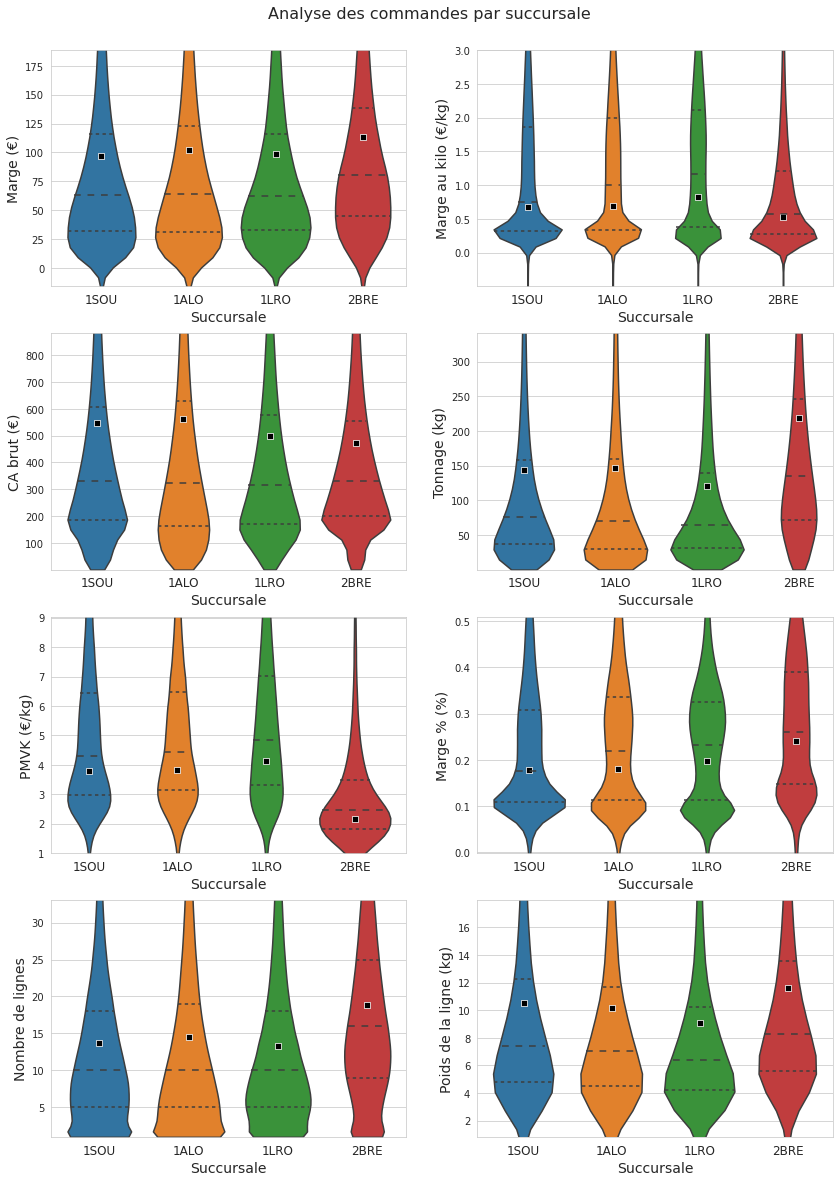

In [37]:
%%time
indicators2 = ['margin', 'brutrevenue',  'PMVK', 'linecount', 'marginperkg', 'weight', 'marginpercent', 'lineweight']
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue=None,
                              hue_order=None,
                              translate=['xaxis', 'indicator',],                              
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par succursale', fontsize=16, y=.91)

In [38]:
utils.pretty_means(data=orders.reset_index(), groupers=['orgacom'], indicators=indicators2)

## Affichage des distributions - par canal de vente

CPU times: user 51 s, sys: 20.8 s, total: 1min 11s
Wall time: 40.5 s


Text(0.5, 0.91, 'Analyse des commandes par canal')

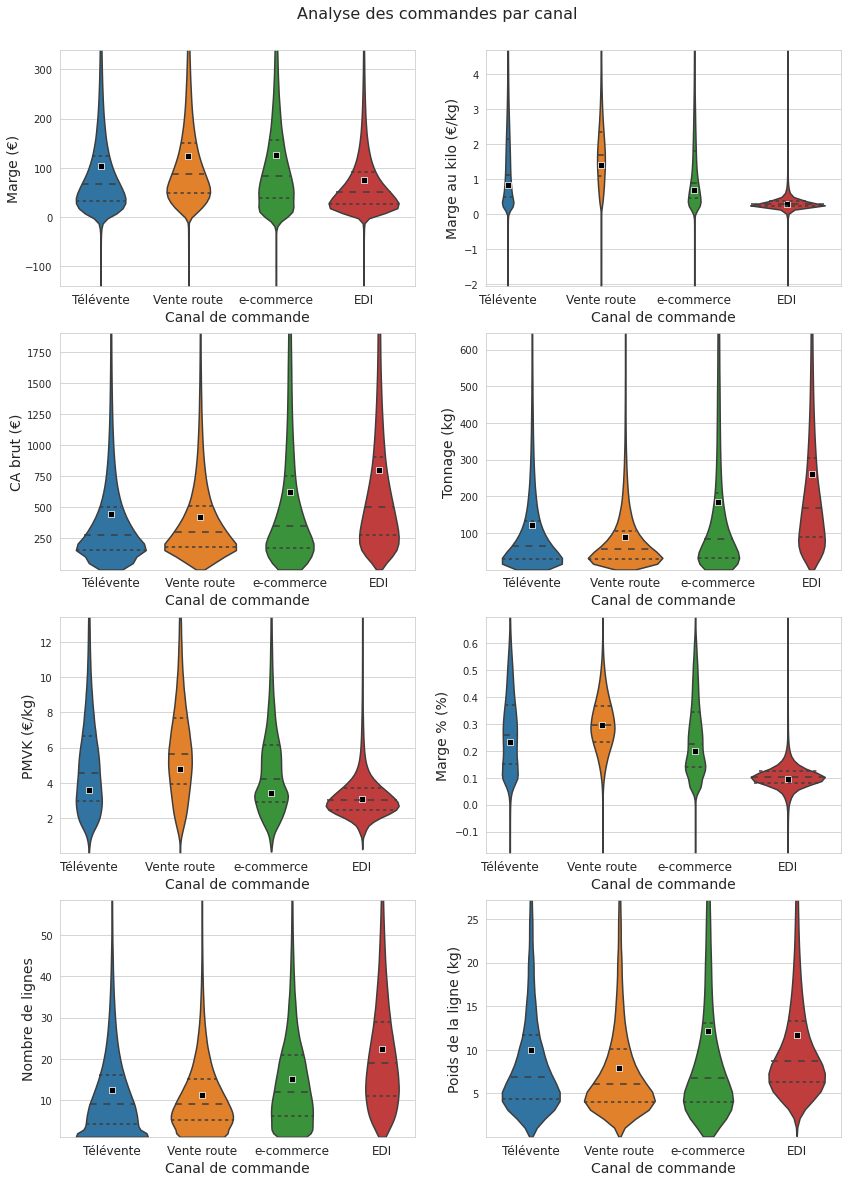

In [39]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)

In [40]:
utils.pretty_means(data=orders.reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - hors O'Tacos

CPU times: user 51.5 s, sys: 20.7 s, total: 1min 12s
Wall time: 41.3 s


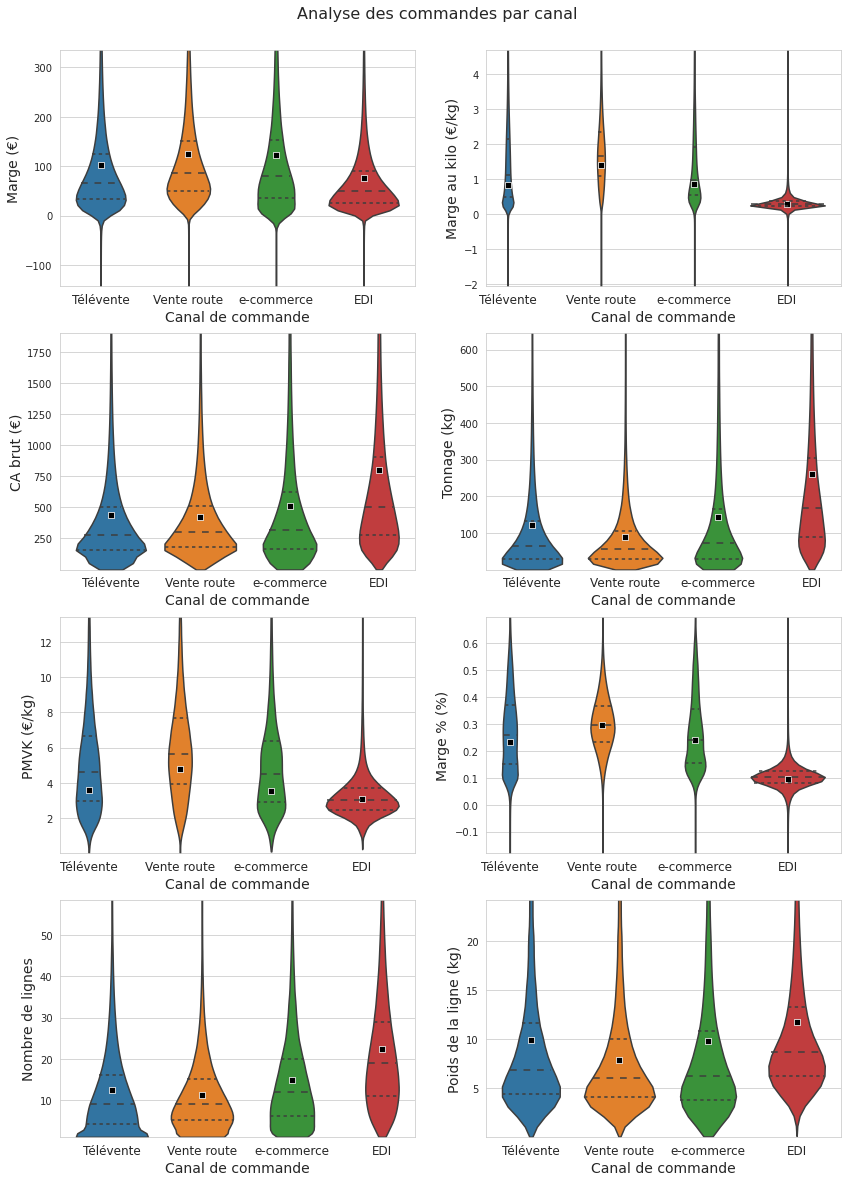

In [41]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=filter_otacos,
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente - uniquement O'Tacos

CPU times: user 688 ms, sys: 48.2 ms, total: 736 ms
Wall time: 735 ms


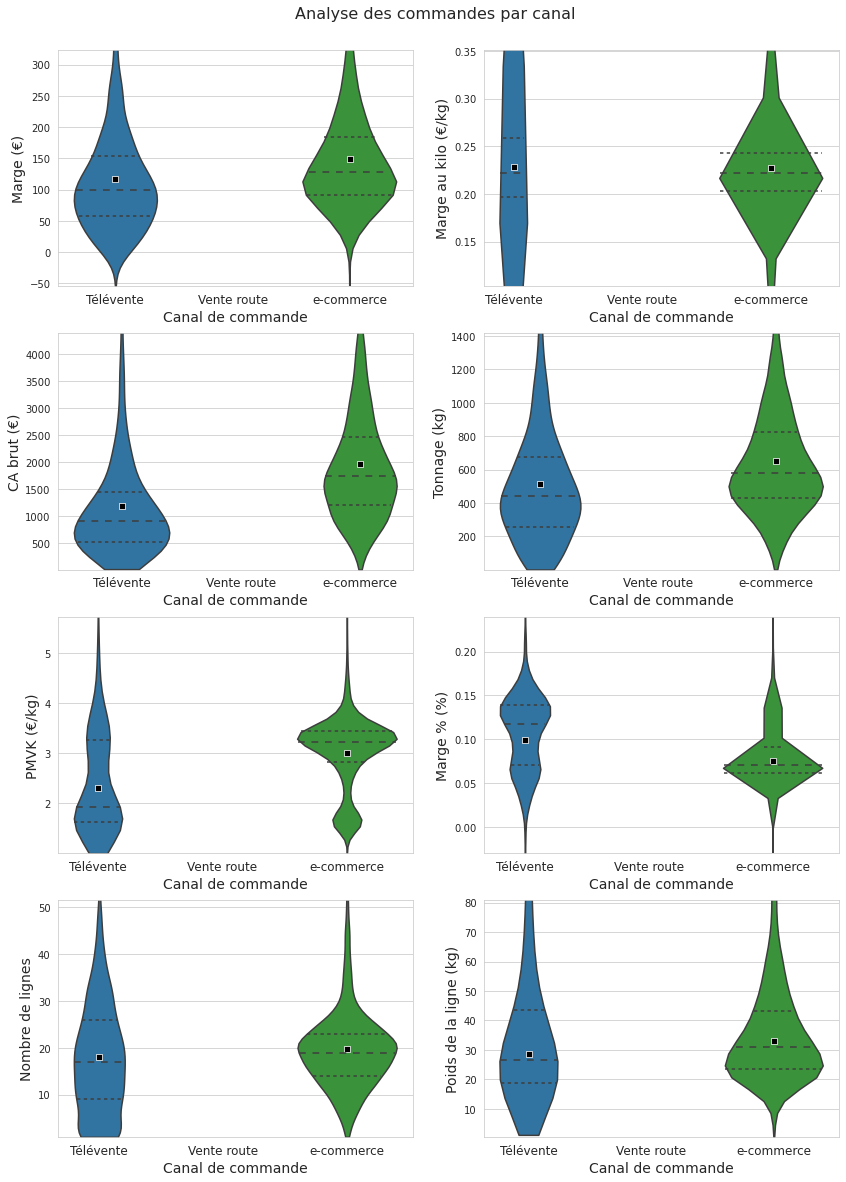

In [42]:
%%time
fig, axs = utils.plot_distrib(data=orders,
                              indicators=indicators2,
                              filter=(~filter_otacos) & (orders.origin2 != 'VR'),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=True,
                              hue=None,
                              hue_order=None,
                              kind='violin',
                              percentile_selection=1.,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(14, 20)
fig.suptitle('Analyse des commandes par canal', fontsize=16, y=.91)
utils.pretty_means(data=orders.loc[~filter_otacos].reset_index(),
                   groupers=['origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par canal de vente et succursale

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


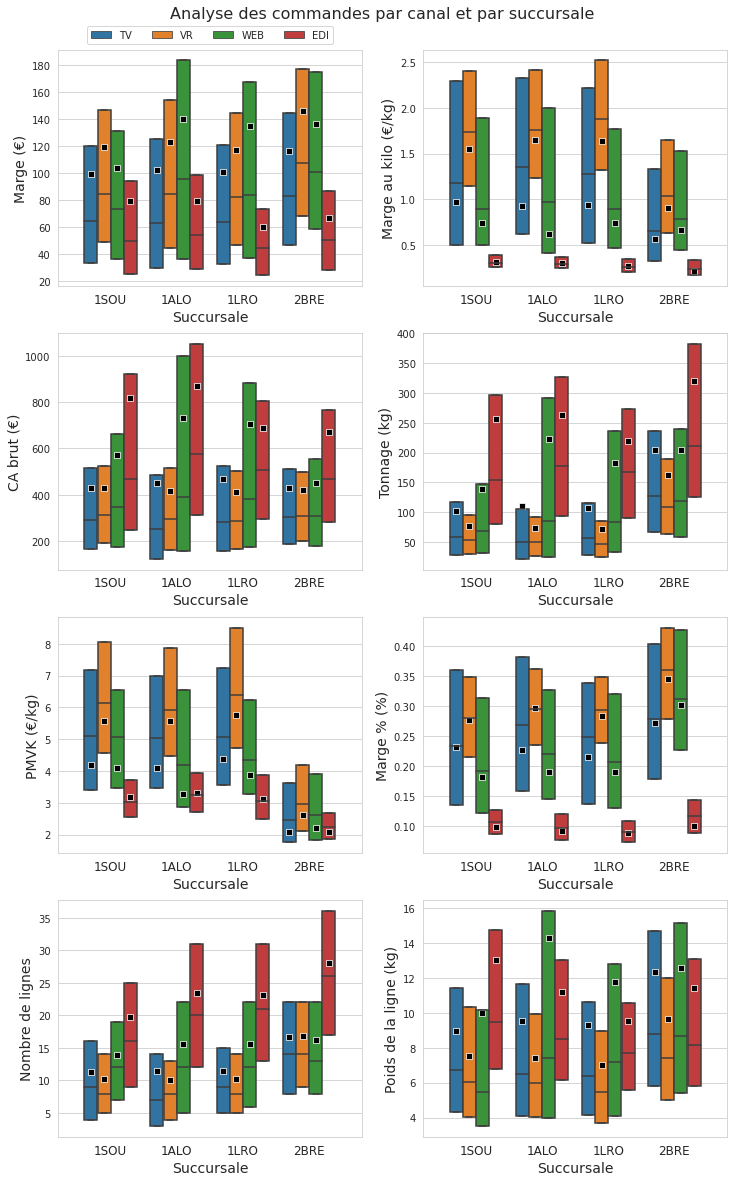

In [43]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=None,
                              show_means=True,
                              plot_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle('Analyse des commandes par canal et par succursale', fontsize=16, y=.91)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'origin2']
                  )

## Affichage des distributions - par segment

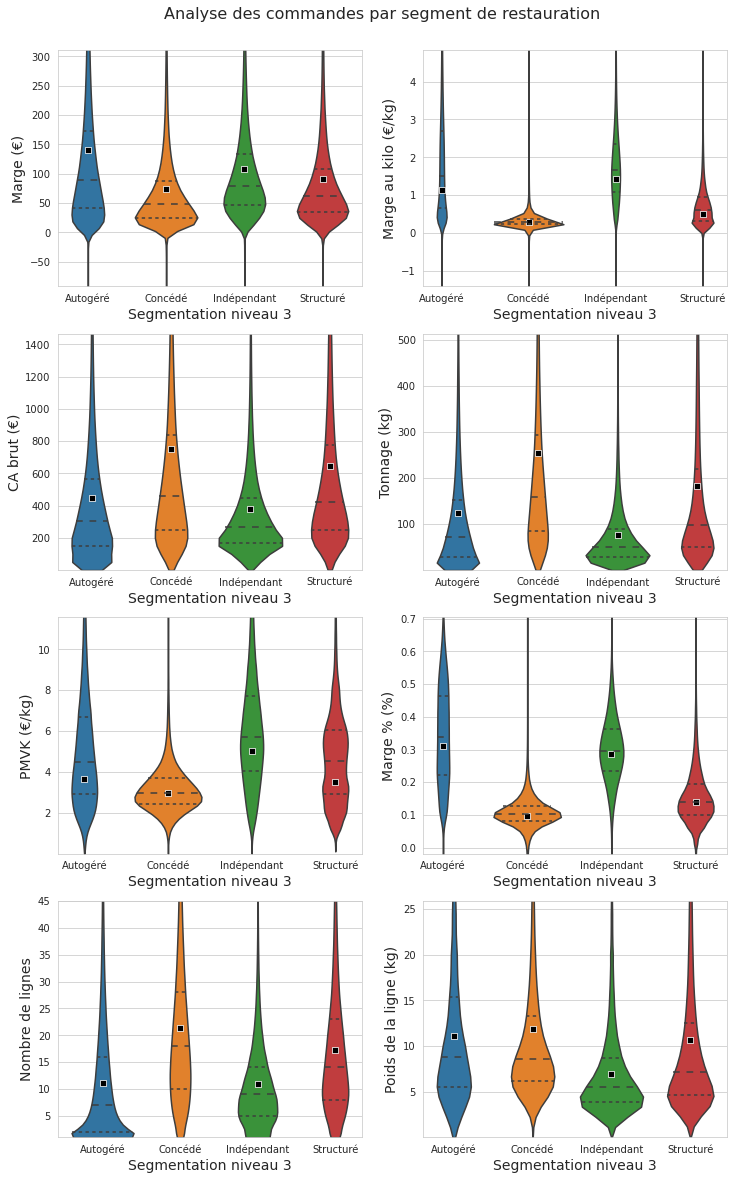

In [44]:
filter_rhd = (orders.seg1 == 'Z3')
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rhd),
                              ncols=2,
#                               hue='origin2',
#                               hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration", fontsize=16, y=.91)
utils.pretty_means(data=orders[filter_rhd].reset_index(),
                   groupers=['seg3'],
                   indicators=indicators2,
                   translate=['columns', 'seg3']
                  )

## Affichage des distributions, par segment et canal de commande

In [45]:
orders.columns

Index(['orgacom', 'date', 'client', 'margin', 'brutrevenue', 'weight',
       'linecount', 'origin2', 'seg1', 'seg2', 'seg3', 'seg4', 'cat', 'sscat',
       'hier4', 'PMVK', 'marginperkg', 'marginpercent', 'lineweight'],
      dtype='object')

In [46]:
filter_main_origins = ~(
    (orders.origin2.isin(['EDI']) & orders.seg3.isin(['ZI', 'ZK'])) |
    (orders.origin2.isin(['VR']) & orders.seg3.isin(['ZJ', 'ZL'])) |
    (orders.origin2.isin(['WEB']) & orders.seg3.isin(['ZJ']))
)
print(len(orders),
      sum(filter_main_origins),
      len(orders) - sum(filter_main_origins),
      f'{(len(orders) - sum(filter_main_origins)) / len(orders):.2%}',
      )

2444326 2428615 15711 0.64%


/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


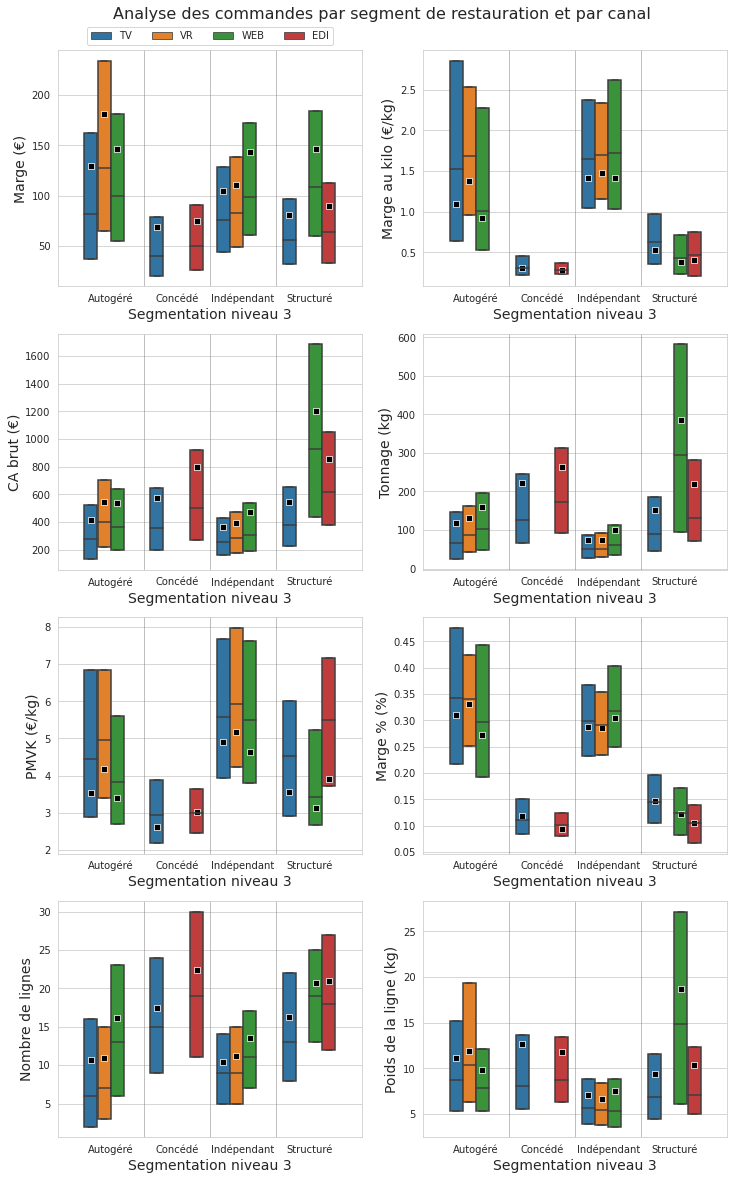

In [47]:
filter_rhd = (orders.seg1 == 'Z3')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rhd & filter_main_origins),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par segment de restauration et par canal", fontsize=16, y=.91)
utils.pretty_means(data=orders[filter_rhd].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators2,
                   translate=['columns', 'seg3', 'origin2']
                  )
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Focus sur le PMVK en RCS

Text(0.5, 0.91, 'Analyse des commandes par canal - Focus RCS')

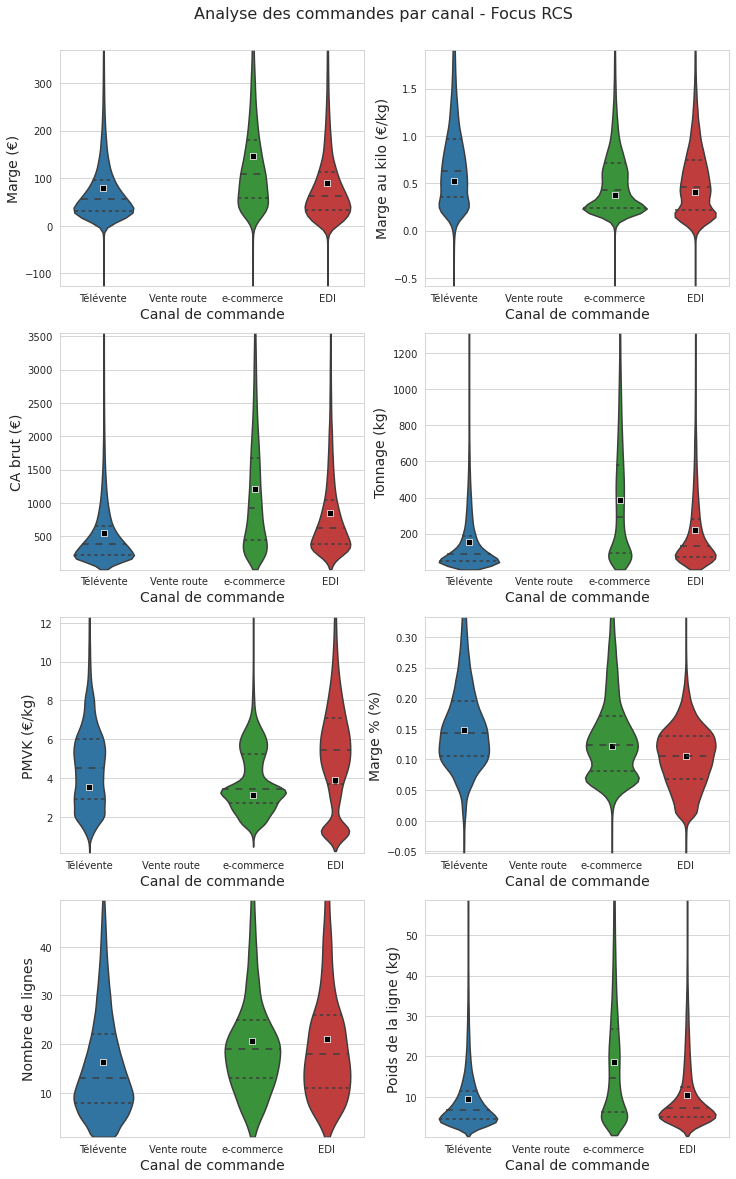

In [48]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              x='origin2',
                              order=['TV', 'VR', 'WEB', 'EDI'],
#                               x='seg3',
#                               order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
                              IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)
# utils.pretty_means(data=orders[filter_rhd & filter_otacos].reset_index(),
#                    groupers=['seg3', 'origin2'],
#                    indicators=indicators2,
#                    translate=['columns', 'seg3', 'origin2']
#                   )
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
# for ax_list in axs:
#     for ax in ax_list:
#         for x in [.5, 1.5, 2.5]:
#             ax.axvline(x, lw=1, color='grey', alpha=.5)
#         ax.get_legend().remove()

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


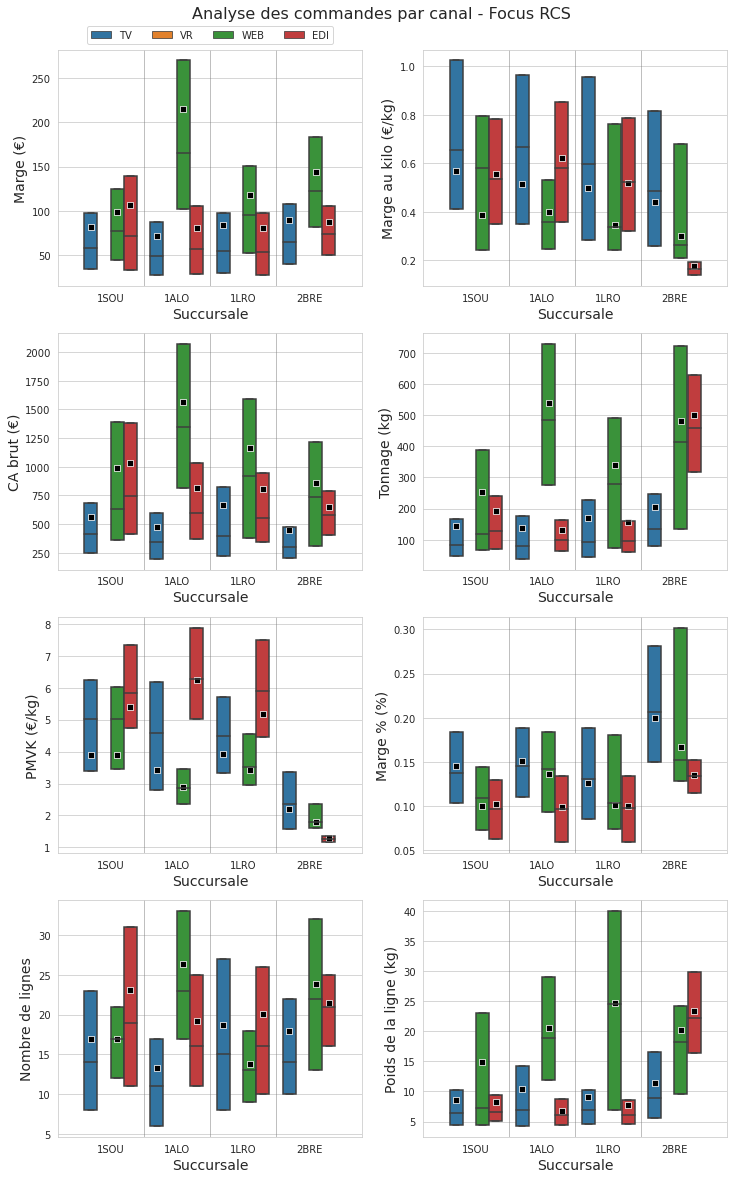

In [49]:
filter_rhd = (orders.seg1 == 'Z3')
filter_rcs = (orders.seg3 == 'ZL')

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators2,
                              filter=(filter_rcs & filter_main_origins),
                              ncols=2,
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
#                               percentile_selection=None,
#                               IQR_factor_selection=None,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - Focus RCS", fontsize=16, y=.91)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)
        ax.get_legend().remove()

## Liens avec la segmentation

In [50]:
reload(utils)

<module 'scripts.utils' from '/home/pmasse/WebOrNot/scripts/utils.py'>

In [51]:
show(partial(utils.bk_bubbles,
             data=orders.loc[(orders.date >= pd.to_datetime('2017-01-01')) &
                             (orders.date <= pd.to_datetime('2019-12-31'))],
             filters=filter_rhd & filter_main_origins,
            ),
     notebook_url="http://devdm:8888")

## Impact du Web sur les indicateurs, à la maille du client

On calcule le zscore sur les indicateurs suivis, **à la maille du client DO**.

In [52]:
orders = compute_zscores(orders,
                         grouper_fields=['orgacom', 'client'],
                         indicators=indicators2)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


Pour un client donné, cela ne change pas le rapport entre les divers indicateurs :

In [53]:
sample = orders.reset_index().loc[orders.reset_index().origin2 == 'WEB'].sample(1).iloc[0]

0000067029 - TUTTI PIZZA AUCAMVILLE


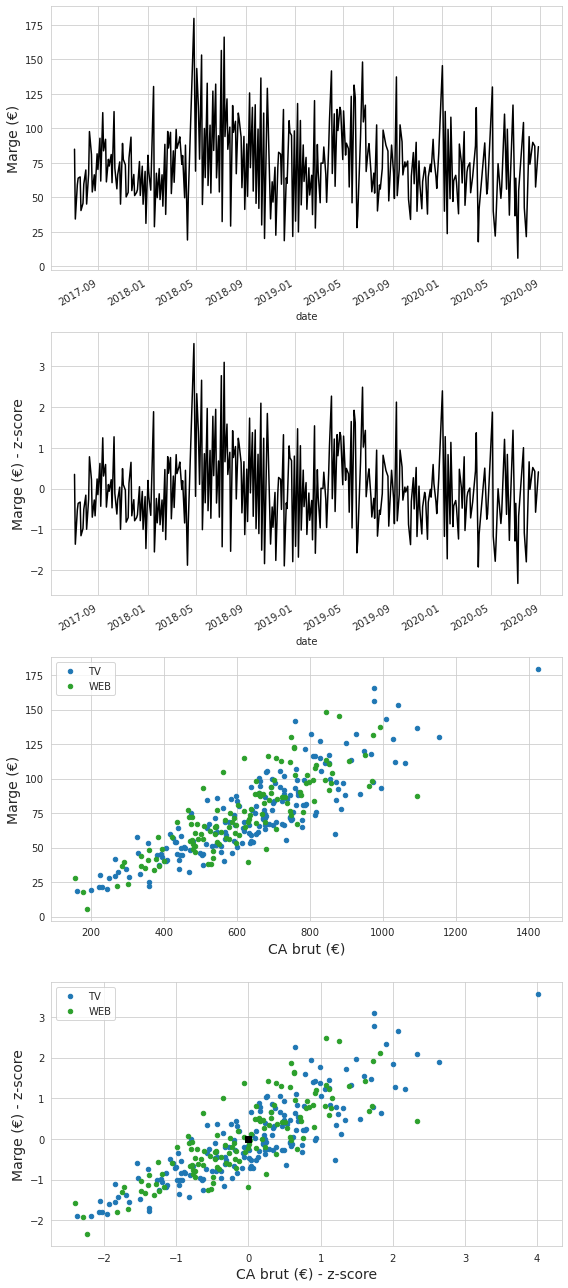

In [54]:
oc, client = '1SOU', '0000067029' #sample.orgacom, sample.client
name = df_clt.loc[(oc, client), 'nom']
print(f'{client} - {name}')
fig, axs = plt.subplots(figsize=(8, 18), nrows=4)
mask_clt = (orders.reset_index().client == client)
mask_web = mask_clt & (orders.reset_index().origin2 == 'WEB')
mask_other = mask_clt & (orders.reset_index().origin2 != 'WEB')
col_web = list(mcolor.TABLEAU_COLORS.values())[2]
col_tv = list(mcolor.TABLEAU_COLORS.values())[0]
(orders.reset_index()
       .loc[mask_other]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_tv, ax=axs[2], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin': 'Marge (€)',
                'brutrevenue': 'CA brut (€)'}, axis=1)
       .plot(kind='scatter', y='Marge (€)', x='CA brut (€)', color=col_web, ax=axs[2], label='WEB')
)

(orders.reset_index()
       .loc[mask_other]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_tv, ax=axs[3], label='TV')
)
(orders.reset_index()
       .loc[mask_web]
       .rename({'margin_clt_zscore': 'Marge (€) - z-score',
                'brutrevenue_clt_zscore': 'CA brut (€) - z-score'}, axis=1)
       .plot(kind='scatter', y='Marge (€) - z-score', x='CA brut (€) - z-score', color=col_web, ax=axs[3], label='WEB')
)

axs[3].scatter(x=[0], y=[0], marker='s', color='black')
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin', x='date', color='black', ax=axs[0])
orders.reset_index().loc[mask_clt].plot(kind='line', y='margin_clt_zscore', x='date', color='black', ax=axs[1])
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[0].set_ylabel('Marge (€)', fontsize=14)
axs[1].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_ylabel('Marge (€)', fontsize=14)
axs[3].set_ylabel('Marge (€) - z-score', fontsize=14)
axs[2].set_xlabel('CA brut (€)', fontsize=14)
axs[3].set_xlabel('CA brut (€) - z-score', fontsize=14)
axs[2].legend()
axs[3].legend()
fig.tight_layout()

### Création d'un exemple fictif

On crée un exemple fictif pour illustrer.

In [55]:
def dt_linspace(start, end, n):
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    t = np.linspace(start.value, end.value, n)
    t = pd.to_datetime(t)
    return(t)
t1 = dt_linspace('2019-01-01', '2019-03-31', 10)
type(t1)

pandas.core.indexes.datetimes.DatetimeIndex

In [56]:
palette = [
    list(mcolor.TABLEAU_COLORS.values())[0],
    list(mcolor.TABLEAU_COLORS.values())[2],
]

len_clt1 = 50
clt1_origin = ['TV'] * len_clt1
web_clt1_indices = [12, 36]
for idx_ in web_clt1_indices:
    clt1_origin[idx_] = 'WEB'


ex_df = [
    pd.DataFrame(
        {
            'client': ['clt1'] * len_clt1,
            'date': dt_linspace('2019-01-01', '2019-03-31',len_clt1),
            'origin': clt1_origin,
            'margin': np.random.normal(size=len_clt1) + [10] * len_clt1,
        }
    ),
    pd.DataFrame(
        {
            'client': ['clt2'] * 15,
            'date': dt_linspace('2019-01-01', '2019-03-22', 15),
            'origin': ['TV'] * 7 + ['WEB'] * 8,
            'margin': np.random.normal(size=15) + ([25] * 7 + [20] * 8),
        }
    )
]
ex_df = pd.concat(ex_df)
ex_df = utils.compute_zscores(ex_df, indicators=['margin'], grouper_fields=['client'])
# sns.scatterplot(data=ex_df, x='date', y='margin', hue=ex_df.origin.to_list(),
#                 palette=palette,
#                 style=ex_df.origin.to_list(),
#                )

margin done!
ALL DONE!


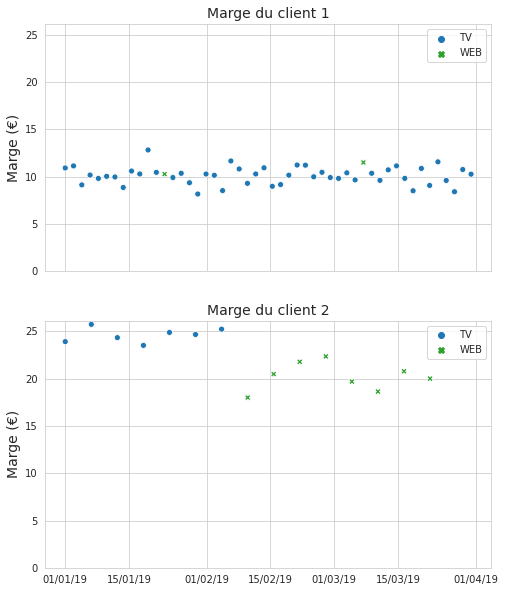

In [57]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[1].set_ylim(0)
axs[0].set_ylim(0, axs[1].get_ylim()[1])
axs[0].set_title('Marge du client 1', fontsize=14)
axs[1].set_title('Marge du client 2', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€)')

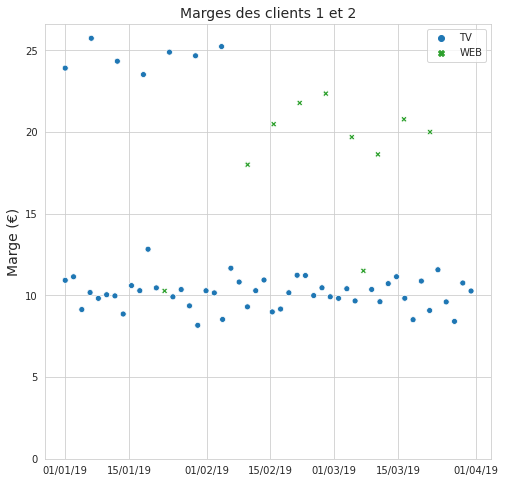

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2', fontsize=14)
ax.set_xlabel(None)
ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€)', fontsize=14)

<AxesSubplot:xlabel='Canal de commande', ylabel='Marge (€) - z-score'>

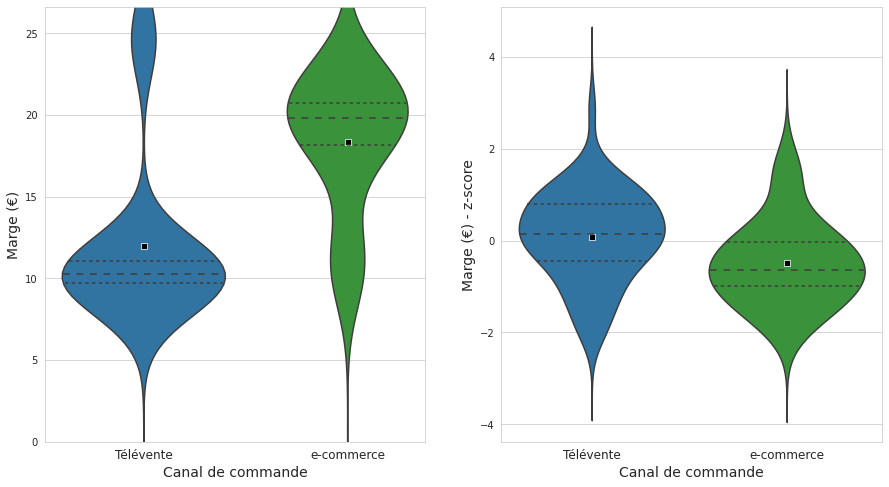

In [59]:
fig, axs = utils.plot_distrib(
    data=ex_df, 
    ncols=2,
    indicators=['margin', 'margin_clt_zscore'],
    x='origin',
    order=['TV', 'WEB'],
    kind='violin',
    percentile_selection=0.99,
    IQR_factor_selection=3.0,
    IQR_factor_plot=None,
    show_means=True,
    plot_kwargs=dict(palette=palette, cut=4.),
    translate=True,
    fontsizes_kwargs=None,    
)
axs[0, 0].set_ylim(0, ax.get_ylim()[1])
axs[0, 1]

In [60]:
utils.pretty_means(data=ex_df,
                   groupers=['origin'],
                   indicators=['margin', 'margin_clt_zscore'],
                   translate=['columns', 'origin']
                  )

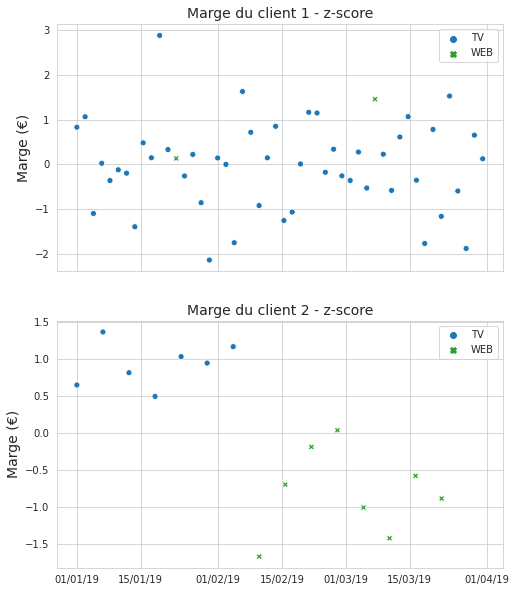

In [61]:
fig, axs = plt.subplots(nrows=2, figsize=(8,10), sharex=True)
to_plot = ex_df.loc[ex_df.client == 'clt1']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[0],
               )
to_plot = ex_df.loc[ex_df.client == 'clt2']
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=axs[1],
               )
axs[0].set_title('Marge du client 1 - z-score', fontsize=14)
axs[1].set_title('Marge du client 2 - z-score', fontsize=14)
axs[1].set_xlabel(None)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
for ax in axs:
    ax.set_ylabel('Marge (€)', fontsize=14)

Text(0, 0.5, 'Marge (€) - z-score')

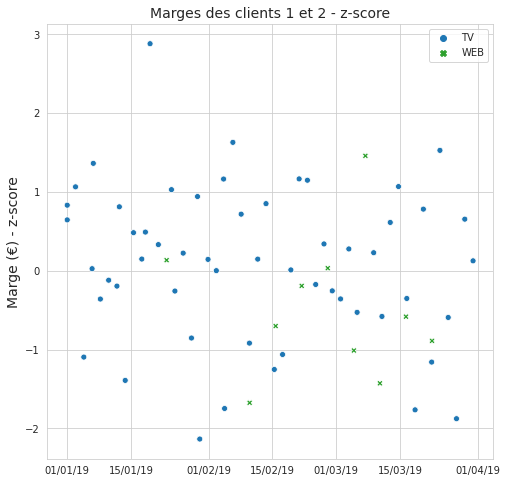

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
to_plot = ex_df
sns.scatterplot(data=to_plot,
                x='date',
                y='margin_clt_zscore',
                hue=to_plot.origin.to_list(),
                palette=palette,
                style=to_plot.origin.to_list(),
                ax=ax,
               )
ax.set_title('Marges des clients 1 et 2 - z-score', fontsize=14)
ax.set_xlabel(None)
# ax.set_ylim(0)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%y"))
ax.set_ylabel('Marge (€) - z-score', fontsize=14)

<AxesSubplot:xlabel='brutrevenue_clt_zscore', ylabel='margin_clt_zscore'>

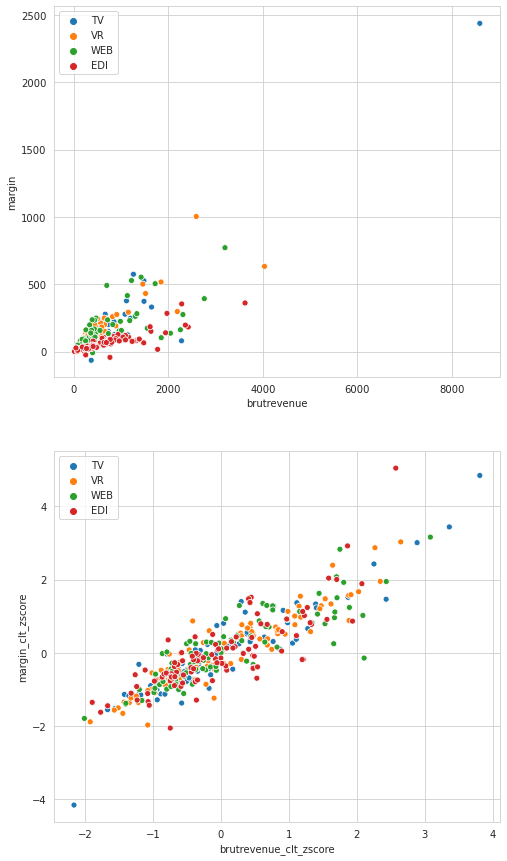

In [63]:
df_sample = pd.concat([orders.loc[orders.origin2 == origin].sample(100) for origin in orders.origin2.unique()], axis=0)

fig, axs = plt.subplots(nrows=2, figsize=(8, 15))
sns.scatterplot(data=df_sample, x='brutrevenue', y='margin', hue=df_sample.origin2.tolist(), ax=axs[0])
sns.scatterplot(data=df_sample, x='brutrevenue_clt_zscore', y='margin_clt_zscore', hue=df_sample.origin2.tolist(), ax=axs[1])

## Affichage des indicateurs en zscore par canal

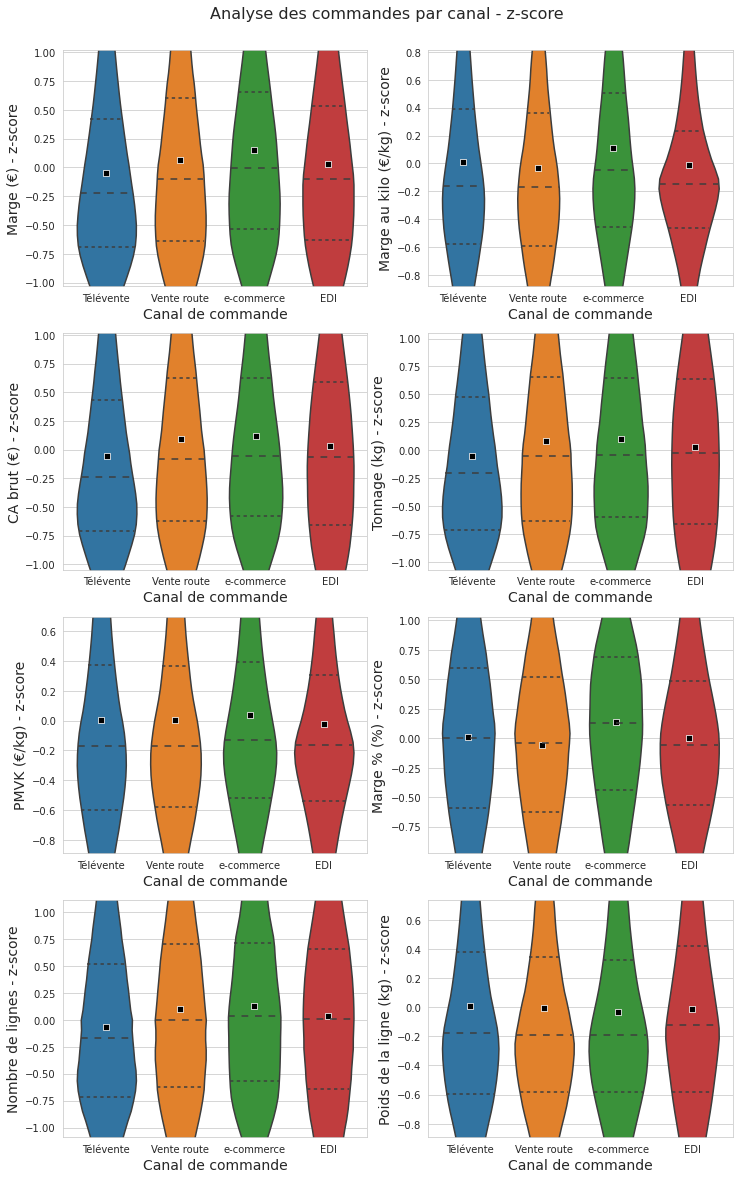

In [64]:
indicators_zscore = [indicator + '_clt_zscore' for indicator in indicators2]

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='origin2',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal - z-score", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et succursale

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


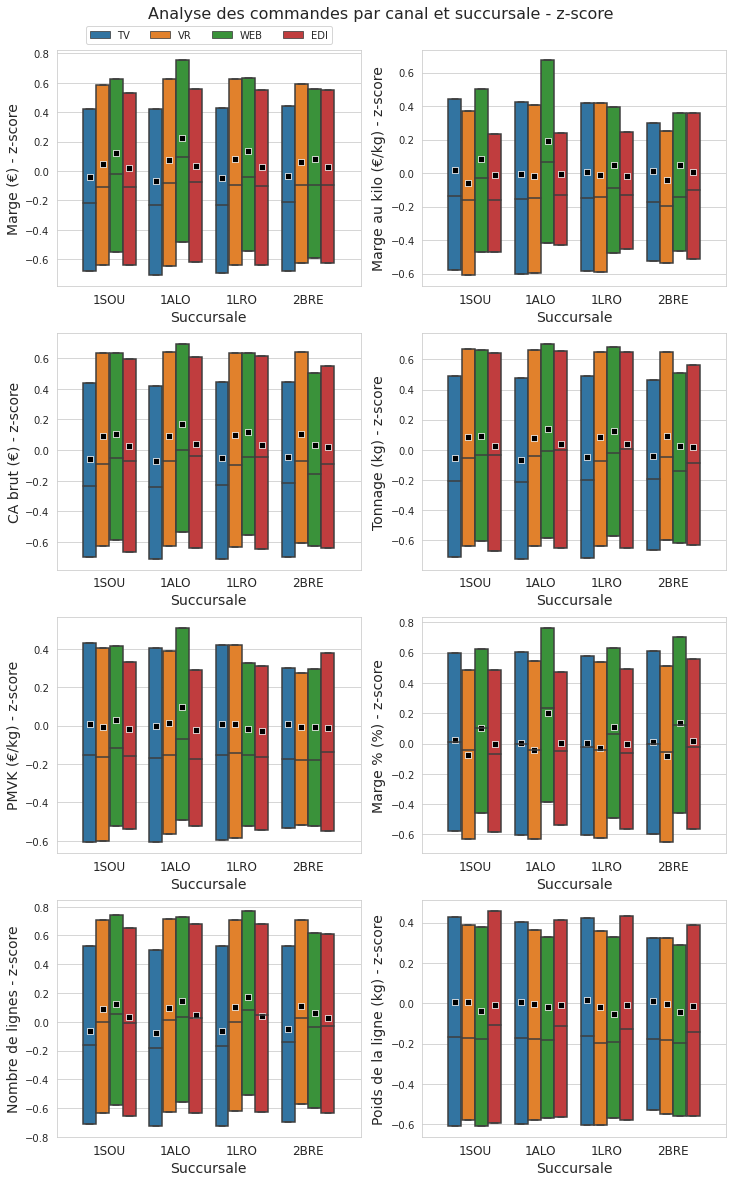

In [65]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', ],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et succursale - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


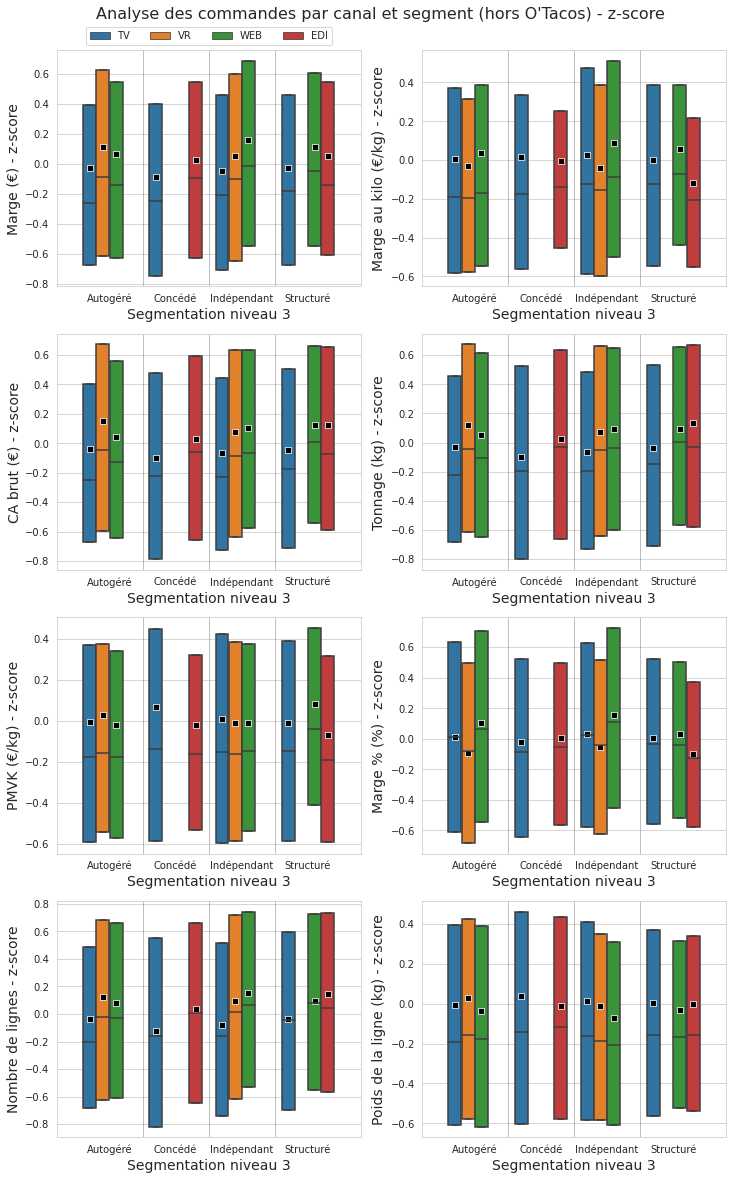

In [66]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_main_origins),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZJ', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        for x in [.5, 1.5, 2.5]:
            ax.axvline(x, lw=1, color='grey', alpha=.5)        
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

In [67]:
utils.pretty_means(data=orders.loc[filter_rhd].reset_index(),
                   groupers=['seg3', 'origin2'],
                   indicators=indicators_zscore,
                   translate=['columns', 'seg3', 'origin2']
                  )

## Affichage des indicateurs en zscore par canal et par segment - hors EDI et SDR

**ATTENTION !!!** Cet indicateur devrait être recalculé, car la filtration du canal EDI filtre une partie des commandes d'un client et donc le zscore n'est plus bon.

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


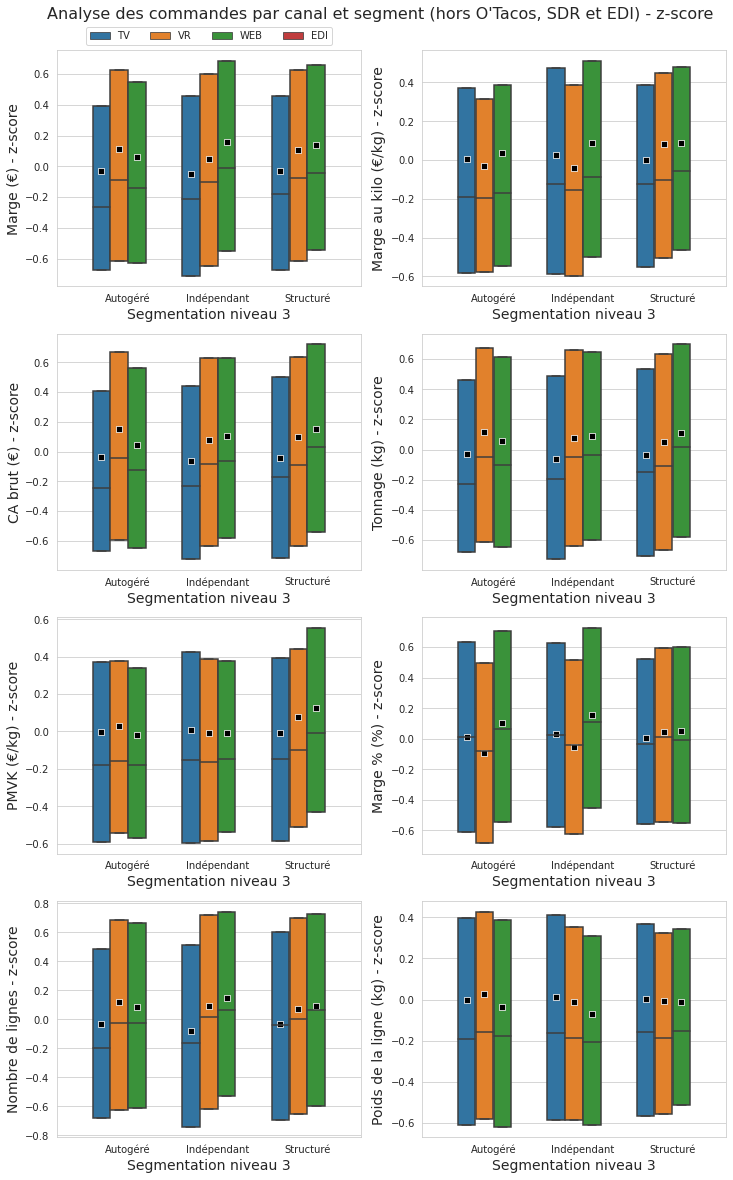

In [68]:
filter_not_edi = ~orders.origin2.isin(['EDI'])
filter_not_sdr = ~orders.seg3.isin(['ZJ'])

fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=(filter_otacos & filter_not_edi & filter_not_sdr & filter_rhd),
                              ncols=2,
                              x='seg3',
                              order=['ZI', 'ZK', 'ZL'],
                              hue='origin2',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
#                               IQR_factor_plot=1.5,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Analyse des commandes par canal et segment (hors O'Tacos, SDR et EDI) - z-score", fontsize=16, y=.91)
for ax_list in axs:
    for ax in ax_list:
        ax.get_legend().remove()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(0, 1, 1, 0.12), bbox_transform=axs[0, 0].transAxes, )
        

## Analyse comportementale, première modélisation : bascule à la première commande Web


# WIP WIP WIP WIP

In [69]:
try:
    orders = orders.set_index(['orgacom', 'client', 'date'])
except KeyError:
    pass

In [70]:
toto = pd.DataFrame({'a': list('111122223333'), 'b': list(range(10, 22))})

toto['new'] = (toto.groupby('a')
                   .transform(lambda x: 3))

toto['with_holes'] = np.where(toto['b'] % 2 == 0, toto.b / 2, np.nan)

toto

a   b  new  with_holes
0   1  10    3         5.0
1   1  11    3         NaN
2   1  12    3         6.0
3   1  13    3         NaN
4   2  14    3         7.0
5   2  15    3         NaN
6   2  16    3         8.0
7   2  17    3         NaN
8   3  18    3         9.0
9   3  19    3         NaN
10  3  20    3        10.0
11  3  21    3         NaN

In [71]:
toto.groupby('a').transform(lambda x: x.mean() * 2)

b  new  with_holes
0   23.0  6.0        11.0
1   23.0  6.0        11.0
2   23.0  6.0        11.0
3   23.0  6.0        11.0
4   31.0  6.0        15.0
5   31.0  6.0        15.0
6   31.0  6.0        15.0
7   31.0  6.0        15.0
8   39.0  6.0        19.0
9   39.0  6.0        19.0
10  39.0  6.0        19.0
11  39.0  6.0        19.0

In [72]:
thresholds = {
    (20, 45): 'petit', 
    (50, 60): 'grand',
    (90, 10000): 'immense'
}

In [73]:
def comp_thresh(val, thresholds):
    '''
    Thresholds are (low, high): target
    They must be sorted in ascending order
    '''
    for low_high, target in thresholds.items():
        if val < low_high[0]:
            return(None)
        if val <= low_high[1]:
            return(target)
    return(None)

In [74]:
def hyst_from_thresh(ds, thresholds=None, initial=None):
    ret = pd.Series(index=ds.index, dtype='object')
    for i, val in enumerate(ds): 
#         print(i, val)
        target = comp_thresh(val, thresholds)
        if target is not None: 
            ret.iloc[i] = target
        else:
            if i == 0:
                ret.iloc[0] = initial
            else:
                ret.iloc[i] = ret.iloc[i-1]
    return(ret)

In [75]:
len(orders)

2444326

In [76]:
orders.margin.tail()

orgacom  client      date      
2BRE     0000282373  2020-08-31    177.42
         0000283953  2020-08-31     43.79
         0000284089  2020-08-31     89.39
         0000284540  2020-08-31    262.04
         0000284735  2020-08-31    319.24
Name: margin, dtype: float64

In [77]:
%%time
orders['margin'].groupby(['orgacom', 'client']).transform(lambda x: hyst_from_thresh(x, thresholds=thresholds ,initial='DEFAULT'))

CPU times: user 1min 39s, sys: 487 ms, total: 1min 40s
Wall time: 1min 40s


orgacom  client      date      
1SOU     0000065940  2017-07-03      petit
                     2017-08-28      petit
                     2017-09-08      petit
                     2017-09-15    immense
                     2017-09-25    immense
                                    ...   
2BRE     0000282373  2020-08-31    immense
         0000283953  2020-08-31      petit
         0000284089  2020-08-31    DEFAULT
         0000284540  2020-08-31    immense
         0000284735  2020-08-31    immense
Name: margin, Length: 2444326, dtype: object

In [78]:
%%time
hyst_from_thresh(orders.margin, thresholds=thresholds ,initial='DEFAULT')

CPU times: user 1min 27s, sys: 32.9 ms, total: 1min 27s
Wall time: 1min 27s


orgacom  client      date      
1SOU     0000065940  2017-07-03      petit
                     2017-08-28      petit
                     2017-09-08      petit
                     2017-09-15    immense
                     2017-09-25    immense
                                    ...   
2BRE     0000282373  2020-08-31    immense
         0000283953  2020-08-31      petit
         0000284089  2020-08-31      petit
         0000284540  2020-08-31    immense
         0000284735  2020-08-31    immense
Length: 2444326, dtype: object

In [79]:
toto = orders.head(5000).margin.groupby(['orgacom', 'client']).rolling(5, win_type='triang', min_periods=1).mean()
toto

orgacom  client                                             
1SOU     0000065940  (1SOU, 0000065940, 2017-07-03 00:00:00)     31.160
                     (1SOU, 0000065940, 2017-08-28 00:00:00)     37.760
                     (1SOU, 0000065940, 2017-09-08 00:00:00)     31.040
                     (1SOU, 0000065940, 2017-09-15 00:00:00)     48.310
                     (1SOU, 0000065940, 2017-09-25 00:00:00)     57.856
                                                                 ...   
         0000066395  (1SOU, 0000066395, 2019-11-12 00:00:00)    179.504
                     (1SOU, 0000066395, 2019-11-18 00:00:00)    124.440
                     (1SOU, 0000066395, 2019-11-25 00:00:00)    146.220
                     (1SOU, 0000066395, 2019-12-02 00:00:00)    128.564
                     (1SOU, 0000066395, 2019-12-09 00:00:00)    132.892
Name: margin, Length: 5000, dtype: float64

In [80]:
orders.index.get_level_values(1).unique()

Index(['0000065940', '0000065945', '0000065975', '0000065998', '0000066014',
       '0000066020', '0000066022', '0000066024', '0000066026', '0000066029',
       ...
       '0000075257', '0000272240', '0000272247', '0000276948', '0000280252',
       '0000282373', '0000283953', '0000284089', '0000284540', '0000284735'],
      dtype='object', name='client', length=33267)

/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2922: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


<AxesSubplot:xlabel='2'>

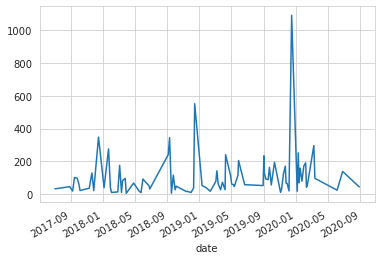

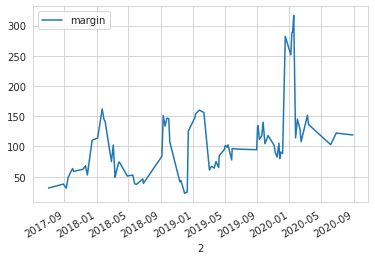

In [81]:
orders.xs(('1SOU', '0000065940')).margin.plot(kind='line')
(
pd.DataFrame(toto.reset_index().level_2.to_list(), index=toto.index).join(toto).reset_index(drop=True)
    .set_index([0, 1, 2]).xs(('1SOU', '0000065940')).plot(kind='line')
)

In [82]:
orders.head(50).margin

orgacom  client      date      
1SOU     0000065940  2017-07-03     31.16
                     2017-08-28     44.36
                     2017-09-08     17.60
                     2017-09-15    100.12
                     2017-09-25     96.04
                     2017-10-02     59.06
                     2017-10-06     20.68
                     2017-11-10     35.23
                     2017-11-20    128.44
                     2017-11-27     20.42
                     2017-12-15    347.30
                     2018-01-05     38.48
                     2018-01-22    274.89
                     2018-01-29     40.02
                     2018-02-02      8.90
                     2018-02-26     12.64
                     2018-03-05    175.01
                     2018-03-12      8.47
                     2018-03-16     80.80
                     2018-03-26     95.47
                     2018-03-30      3.94
                     2018-04-27     66.70
                     2018-05-18     16.24
  

# WIP WIP WIP WIP

Dans un premier temps, on va considérer que la bascule se fait à la première commande Web. Les hypothèses sont : 
- le statut est initialement le canal de la première commande
- ensuite, il est 'WEB' à partir de la première commande web

On commence par calculer le statut initial de chaque client

In [83]:
try:
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )
except KeyError: 
    orders = orders.reset_index()
    first_order = (
        orders.groupby(['orgacom', 'client'], observed=True)['date']
              .min()
              .reset_index()
        )    

On initialise la table des mises à jour de statuts :

In [84]:
status_updates = (
    orders[['orgacom',
            'client',
            'date',
            'origin2']].merge(first_order,
                              on=['orgacom', 'client', 'date'],
                              how='inner',
                              validate='1:1')
                       .rename({'origin2': 'new_stat'}, axis=1)
                       .set_index(['orgacom', 'client', 'date'])
)

On complète en ajoutant la première commande WEB (si elle n'est pas également la première commande).

In [85]:
status_updates2 = (
orders.loc[orders.origin2 == 'WEB']
      .groupby(['client', 'orgacom'], observed=True)['date']
      .min()
      .reset_index()
      .set_index(['orgacom', 'client', 'date'])
)
status_updates2['new_stat'] = 'WEB'
status_updates = (status_updates.append(status_updates2.loc[~status_updates2.index.isin(status_updates.index)])
                                .sort_values(['orgacom', 'client', 'date'])
                 )
status_updates = status_updates.sort_index()
del(status_updates2)
if len(status_updates.loc[status_updates.index.duplicated(keep=False)]) > 0.:
    raise RuntimeError('Something went wrong in computing statuses!')

In [86]:
status_updates

new_stat
orgacom client     date               
1SOU    0000010078 2017-07-17       TV
                   2017-11-06      WEB
        0000019613 2017-07-04       TV
        0000043428 2017-07-04       TV
        0000043827 2019-07-12       VR
...                                ...
2BRE    SL008B     2017-12-01       TV
        SL008C     2017-07-11       TV
        SL008R     2017-07-28       TV
        SL009N     2017-07-04       TV
        SLD008B    2018-09-14       TV

[37000 rows x 1 columns]

On rappatrie le statut calculé depuis la tables des mises à jour de statut (`status_updates`) dans la table des commandes (`orders`).

In [87]:
statuses = (
    status_updates.reindex(status_updates.index.union(orders.set_index(['orgacom', 'client', 'date']).index))
                  .sort_index()
                  .fillna(method='ffill')
                  .rename({'new_stat': 'clt_stat'}, axis=1)
)

try:
    del(orders['clt_stat'])
except KeyError:
    pass       

orders2 = (
orders.set_index(['orgacom', 'client', 'date'])
      .merge(statuses, left_index=True, right_index=True, how='left', indicator=True, validate='1:1')
) 
    
if len(orders2.loc[orders2._merge != 'both']) > 0: 
    raise RuntimeError('Something went wrong during statuses computation')
if len(orders2) != len(orders):
    raise RuntimeError('Something went wrong during statuses computation')
orders = orders2
del(statuses)
del(orders['_merge'])

In [88]:
orders.sample(5)

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1ALO    0000097995 2019-10-10  488.79      1063.53  157.410          2   
1SOU    0000146325 2019-10-22   91.05       310.17   47.711         14   
        0000194786 2020-02-12    7.71        39.86   21.500          4   
        0000257997 2020-02-19   22.69       219.80   38.234         12   
1ALO    0000191117 2018-06-01  -11.77      1057.42  261.350         31   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1ALO    0000097995 2019-10-10      VR   Z3   Z4   ZI   ZB  ZL  ...  78.705000   
1SOU    0000146325 2019-10-22      VR   Z3   Z5   ZK   ZG  ZS  ...   3.407929   
        0000194786 2020-02-12     EDI   Z3   Z4   ZJ   ZF  ZM  ...   5.375000   
        0000257997 2020-02-19      TV   Z3   Z5   ZL   ZH  ZU  ...   3.186167   
1ALO    0000191117 2018-06-01     EDI   Z3   Z4   ZJ   ZF  ZP  ...   8.430645   

                              margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1ALO    0000097995 2019-10-10          2.213625                1.444527   
1SOU    0000146325 2019-10-22          1.232898                1.248531   
        0000194786 2020-02-12         -0.762860               -1.379166   
        0000257997 2020-02-19         -0.480248               -0.393705   
1ALO    0000191117 2018-06-01         -0.654087                0.801230   

                               PMVK_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                
1ALO    0000097995 2019-10-10        -0.327540             -0.287222   
1SOU    0000146325 2019-10-22         0.062514              1.680419   
        0000194786 2020-02-12        -1.459945             -1.195224   
        0000257997 2020-02-19        -0.543267             -0.137543   
1ALO    0000191117 2018-06-01        -0.564797              0.672723   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date                                                    
1ALO    0000097995 2019-10-10               -0.144947           1.803791   
1SOU    0000146325 2019-10-22                0.117085           0.938959   
        0000194786 2020-02-12               -0.341819          -1.078921   
        0000257997 2020-02-19               -0.470040          -0.245663   
1ALO    0000191117 2018-06-01               -0.509573           1.212809   

                               marginpercent_clt_zscore  \
orgacom client     date                                   
1ALO    0000097995 2019-10-10                  0.363578   
1SOU    0000146325 2019-10-22                  0.183138   
        0000194786 2020-02-12                  1.545231   
        0000257997 2020-02-19                 -0.301302   
1ALO    0000191117 2018-06-01                 -0.643976   

                               lineweight_clt_zscore  clt_stat  
orgacom client     date                                         
1ALO    0000097995 2019-10-10               2.519256       WEB  
1SOU    0000146325 2019-10-22              -0.701260        TV  
        0000194786 2020-02-12               0.001808       EDI  
        0000257997 2020-02-19              -0.317117        TV  
1ALO    0000191117 2018-06-01               0.342056       EDI  

[5 rows x 25 columns]

On rappatrie ensuite de quoi calculer les indicateurs dans la table des mises à jour de statut.

In [89]:
(
orders.groupby(['orgacom', 'client', 'clt_stat'], observed=True)
      .agg({'margin': 'sum',
            'brutrevenue': 'sum', 
            'weight': 'sum', 
            'linecount': 'sum', 
            'origin2': 'size',
           })
      .rename({'origin2': 'ordercount'}, axis=1)
)

margin  brutrevenue      weight  linecount  \
orgacom client     clt_stat                                                 
1SOU    0000010078 TV           11.01        20.82       2.350          2   
                   WEB         221.62       452.95      25.460         18   
        0000019613 TV        47824.80    470059.03  129763.078       5624   
        0000043428 TV        20550.61    107904.93   24274.185       3153   
        0000043827 VR          922.65      4220.09     862.249        116   
...                               ...          ...         ...        ...   
2BRE    SL008B     TV          190.97      4398.58    3303.984          2   
        SL008C     TV         7578.42     71848.30   21946.816        367   
        SL008R     TV          263.63      6992.88    2009.948         43   
        SL009N     TV         5107.84     14556.72    4057.578        172   
        SLD008B    TV            3.82        70.05       4.400          1   

                             ordercount  
orgacom client     clt_stat              
1SOU    0000010078 TV                 1  
                   WEB                6  
        0000019613 TV               485  
        0000043428 TV               163  
        0000043827 VR                 9  
...                                 ...  
2BRE    SL008B     TV                 2  
        SL008C     TV                95  
        SL008R     TV                25  
        SL009N     TV                48  
        SLD008B    TV                 1  

[37000 rows x 5 columns]

In [90]:
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'new_stat']).join(
    orders.rename({'clt_stat': 'new_stat'}, axis=1)
          .groupby(['orgacom', 'client', 'new_stat'], observed=True)
          .agg({'margin': 'sum',
                'brutrevenue': 'sum', 
                'weight': 'sum', 
                'linecount': 'sum', 
                'origin2': 'size',
               })
          .rename({'origin2': 'ordercount'}, axis=1)         
)
status_updates

date    margin  brutrevenue      weight  \
orgacom client     new_stat                                                 
1SOU    0000010078 TV       2017-07-17     11.01        20.82       2.350   
                   WEB      2017-11-06    221.62       452.95      25.460   
        0000019613 TV       2017-07-04  47824.80    470059.03  129763.078   
        0000043428 TV       2017-07-04  20550.61    107904.93   24274.185   
        0000043827 VR       2019-07-12    922.65      4220.09     862.249   
...                                ...       ...          ...         ...   
2BRE    SL008B     TV       2017-12-01    190.97      4398.58    3303.984   
        SL008C     TV       2017-07-11   7578.42     71848.30   21946.816   
        SL008R     TV       2017-07-28    263.63      6992.88    2009.948   
        SL009N     TV       2017-07-04   5107.84     14556.72    4057.578   
        SLD008B    TV       2018-09-14      3.82        70.05       4.400   

                             linecount  ordercount  
orgacom client     new_stat                         
1SOU    0000010078 TV                2           1  
                   WEB              18           6  
        0000019613 TV             5624         485  
        0000043428 TV             3153         163  
        0000043827 VR              116           9  
...                                ...         ...  
2BRE    SL008B     TV                2           2  
        SL008C     TV              367          95  
        SL008R     TV               43          25  
        SL009N     TV              172          48  
        SLD008B    TV                1           1  

[37000 rows x 6 columns]

In [91]:
status_updates['PMVK'] = status_updates.brutrevenue / status_updates.weight
status_updates['marginperkg'] = status_updates.margin / status_updates.weight
status_updates['marginpercent'] = status_updates.margin / status_updates.brutrevenue
status_updates['lineweight'] = status_updates.weight / status_updates.linecount
for indicator in ['margin', 'brutrevenue', 'weight', 'linecount']:
    status_updates[indicator] /= status_updates['ordercount']
status_updates = status_updates.reset_index().set_index(['orgacom', 'client', 'date'])
status_updates

new_stat      margin  brutrevenue       weight  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17       TV   11.010000    20.820000     2.350000   
                   2017-11-06      WEB   36.936667    75.491667     4.243333   
        0000019613 2017-07-04       TV   98.607835   969.193876   267.552738   
        0000043428 2017-07-04       TV  126.077362   661.993436   148.921380   
        0000043827 2019-07-12       VR  102.516667   468.898889    95.805444   
...                                ...         ...          ...          ...   
2BRE    SL008B     2017-12-01       TV   95.485000  2199.290000  1651.992000   
        SL008C     2017-07-11       TV   79.772842   756.297895   231.019116   
        SL008R     2017-07-28       TV   10.545200   279.715200    80.397920   
        SL009N     2017-07-04       TV  106.413333   303.265000    84.532875   
        SLD008B    2018-09-14       TV    3.820000    70.050000     4.400000   

                               linecount  ordercount       PMVK  marginperkg  \
orgacom client     date                                                        
1SOU    0000010078 2017-07-17   2.000000           1   8.859574     4.685106   
                   2017-11-06   3.000000           6  17.790652     8.704635   
        0000019613 2017-07-04  11.595876         485   3.622441     0.368555   
        0000043428 2017-07-04  19.343558         163   4.445254     0.846604   
        0000043827 2019-07-12  12.888889           9   4.894282     1.070051   
...                                  ...         ...        ...          ...   
2BRE    SL008B     2017-12-01   1.000000           2   1.331296     0.057800   
        SL008C     2017-07-11   3.863158          95   3.273746     0.345308   
        SL008R     2017-07-28   1.720000          25   3.479135     0.131163   
        SL009N     2017-07-04   3.583333          48   3.587539     1.258840   
        SLD008B    2018-09-14   1.000000           1  15.920455     0.868182   

                               marginpercent   lineweight  
orgacom client     date                                    
1SOU    0000010078 2017-07-17       0.528818     1.175000  
                   2017-11-06       0.489281     1.414444  
        0000019613 2017-07-04       0.101742    23.073094  
        0000043428 2017-07-04       0.190451     7.698758  
        0000043827 2019-07-12       0.218633     7.433181  
...                                      ...          ...  
2BRE    SL008B     2017-12-01       0.043416  1651.992000  
        SL008C     2017-07-11       0.105478    59.800589  
        SL008R     2017-07-28       0.037700    46.742977  
        SL009N     2017-07-04       0.350892    23.590570  
        SLD008B    2018-09-14       0.054532     4.400000  

[37000 rows x 10 columns]

In [92]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000065940 2017-07-03   31.16        84.01    5.501          9   
                   2017-08-28   44.36       105.93    8.048         10   
                   2017-09-08   17.60        40.35    3.000          2   
                   2017-09-15  100.12       236.77   20.312          3   
                   2017-09-25   96.04       253.99   40.338          5   
...                               ...          ...      ...        ...   
2BRE    0000282373 2020-08-31  177.42      1401.58  488.036         88   
        0000283953 2020-08-31   43.79       421.67  564.980         28   
        0000284089 2020-08-31   89.39       186.75   90.200         12   
        0000284540 2020-08-31  262.04      1252.07  639.326         97   
        0000284735 2020-08-31  319.24       782.56  235.236         58   

                              origin2 seg1 seg2 seg3 seg4 cat  ... lineweight  \
orgacom client     date                                        ...              
1SOU    0000065940 2017-07-03      TV   Z3   Z4   ZI   ZB  ZL  ...   0.611222   
                   2017-08-28      TV   Z3   Z4   ZI   ZB  ZL  ...   0.804800   
                   2017-09-08      TV   Z3   Z4   ZI   ZB  ZL  ...   1.500000   
                   2017-09-15      TV   Z3   Z4   ZI   ZB  ZL  ...   6.770667   
                   2017-09-25      TV   Z3   Z4   ZI   ZB  ZL  ...   8.067600   
...                               ...  ...  ...  ...  ...  ..  ...        ...   
2BRE    0000282373 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZP  ...   5.545864   
        0000283953 2020-08-31     EDI   Z3   Z4   ZJ   ZF  ZN  ...  20.177857   
        0000284089 2020-08-31      TV   Z3   Z5   ZK   ZG  ZU  ...   7.516667   
        0000284540 2020-08-31      TV   Z3   Z4   ZJ   ZF  ZP  ...   6.590990   
        0000284735 2020-08-31      VR   Z3   Z5   ZK   ZG  ZU  ...   4.055793   

                              margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom client     date                                                   
1SOU    0000065940 2017-07-03         -0.515855               -0.420589   
                   2017-08-28         -0.423595               -0.376466   
                   2017-09-08         -0.610631               -0.508474   
                   2017-09-15         -0.033868               -0.113095   
                   2017-09-25         -0.062385               -0.078432   
...                                         ...                     ...   
2BRE    0000282373 2020-08-31          0.000000                0.000000   
        0000283953 2020-08-31          0.000000                0.000000   
        0000284089 2020-08-31          0.000000                0.000000   
        0000284540 2020-08-31          0.000000                0.000000   
        0000284735 2020-08-31          0.000000                0.000000   

                               PMVK_clt_zscore  linecount_clt_zscore  \
orgacom client     date                                                
1SOU    0000065940 2017-07-03         0.842437              2.795673   
                   2017-08-28         0.423512              3.252761   
                   2017-09-08         0.480651             -0.403938   
                   2017-09-15         0.124511              0.053150   
                   2017-09-25        -0.939954              0.967324   
...                                        ...                   ...   
2BRE    0000282373 2020-08-31         0.000000              0.000000   
        0000283953 2020-08-31         0.000000              0.000000   
        0000284089 2020-08-31         0.000000              0.000000   
        0000284540 2020-08-31         0.000000              0.000000   
        0000284735 2020-08-31         0.000000              0.000000   

                               marginperkg_clt_zscore  weight_clt_zscore  \
orgacom client     date  

In [93]:
status_updates = compute_zscores(status_updates, ['orgacom', 'client'], indicators2)

margin done!
brutrevenue done!
PMVK done!
linecount done!
marginperkg done!
weight done!
marginpercent done!
lineweight done!
ALL DONE!


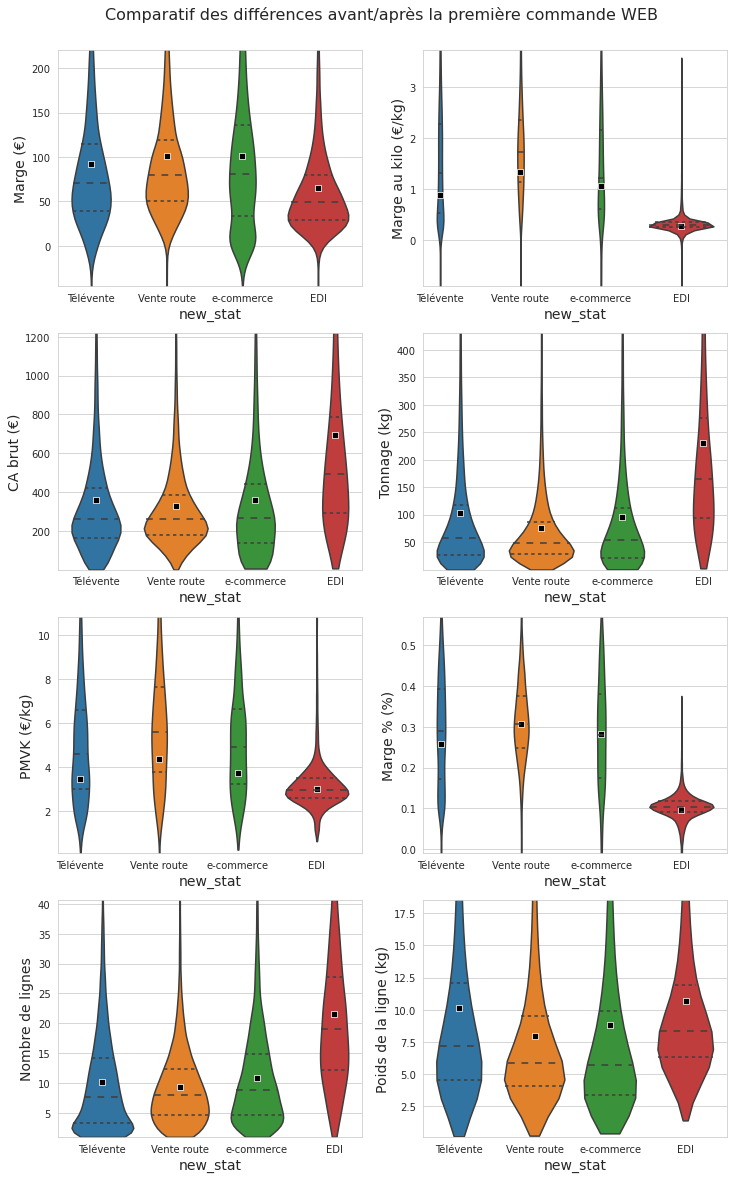

In [94]:
fig, axs = utils.plot_distrib(data=status_updates.reset_index(),
                              indicators=indicators2,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='new_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(whis=1.5),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB", fontsize=16, y=.91)

utils.pretty_means(data=status_updates.reset_index(),
                   groupers=['new_stat'],
                   indicators=indicators2,
                   translate=['columns', 'new_stat']
                  )

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


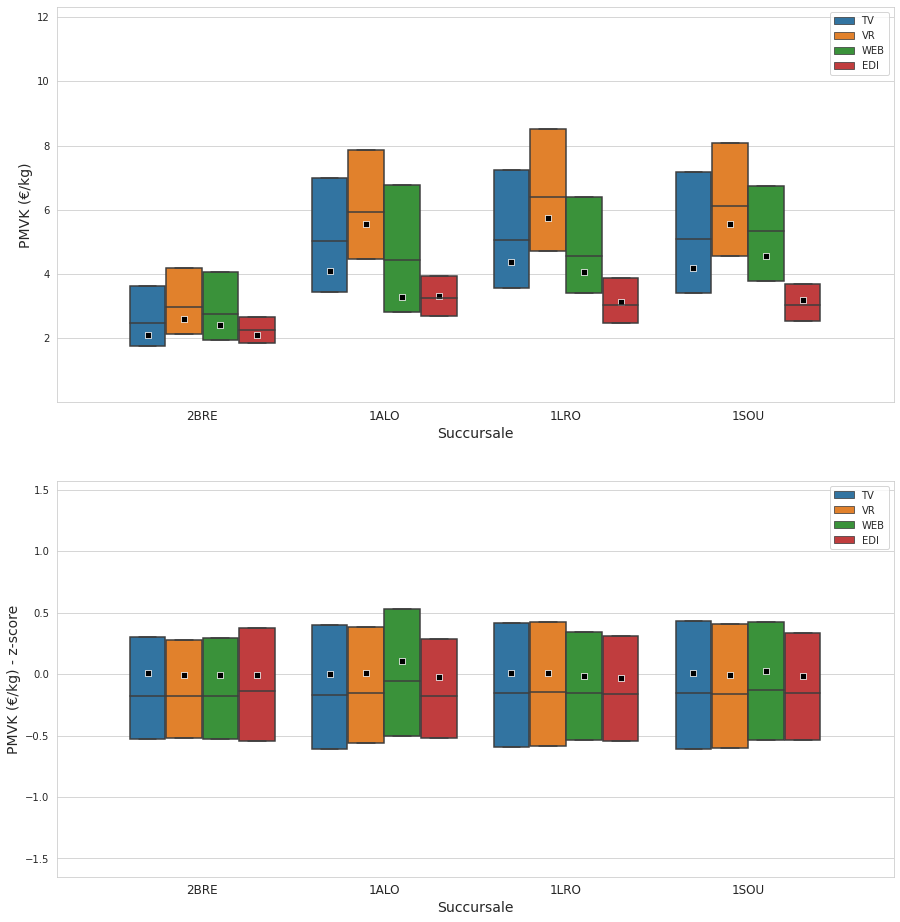

In [95]:
fig, axs = utils.plot_distrib(data=orders,
                              filter=filter_otacos, 
                              indicators=['PMVK', 'PMVK_clt_zscore'],
                              hue='origin2',
                              hue_order=['TV', 'VR', 'WEB', 'EDI'],
                              x='orgacom', #'origin2', 
                              order=['2BRE', '1ALO', '1LRO', '1SOU',],
                              kind='boxplot',
                              percentile_selection=.98,
                              IQR_factor_selection=1.5,
                              IQR_factor_plot=1.,
                              show_means=True,
                              translate=['xaxis', 'indicator'],
                             )

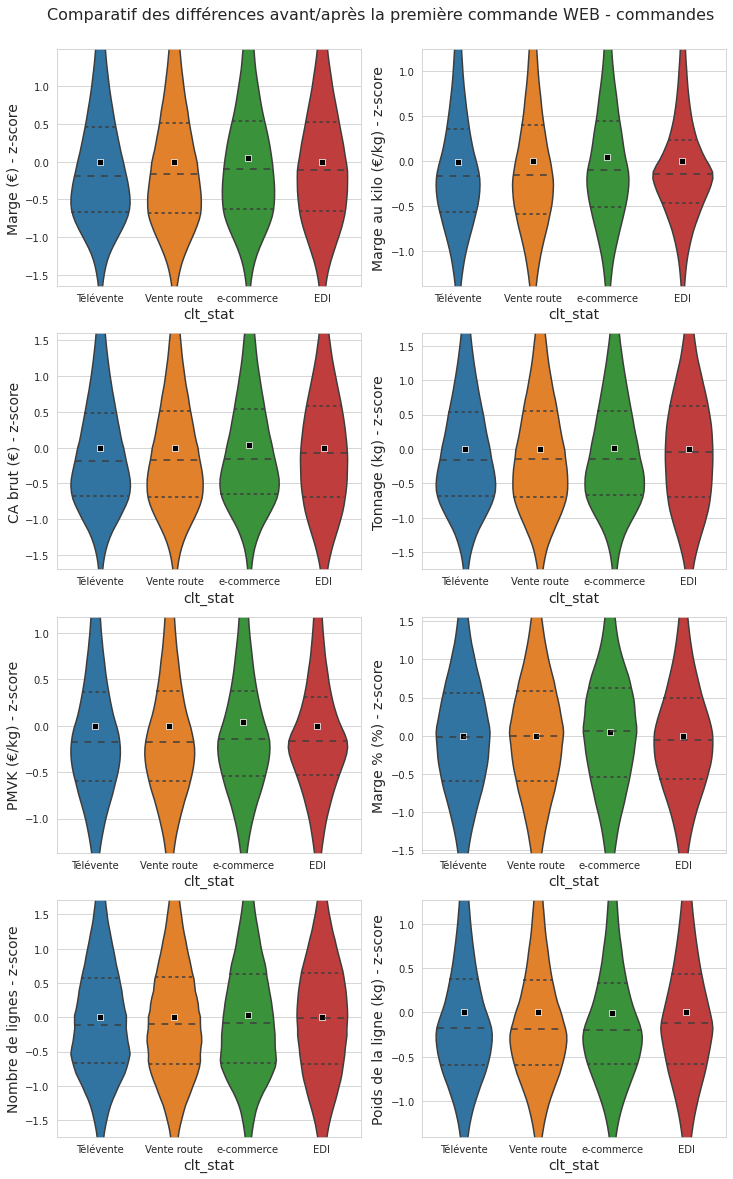

In [96]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              hue=None,
                              hue_order=None,
                              x='clt_stat',
                              order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator', 'x'],
                              kind='violin',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.8,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['clt_stat'],
                   indicators=indicators2,
                   translate=['columns', 'clt_stat']
                  )

/home/pmasse/WebOrNot/scripts/utils.py:464: UserWarning: Selection parameters have been given for a boxplot. They will be ignored.
  warnings.warn('Selection parameters have been given for '


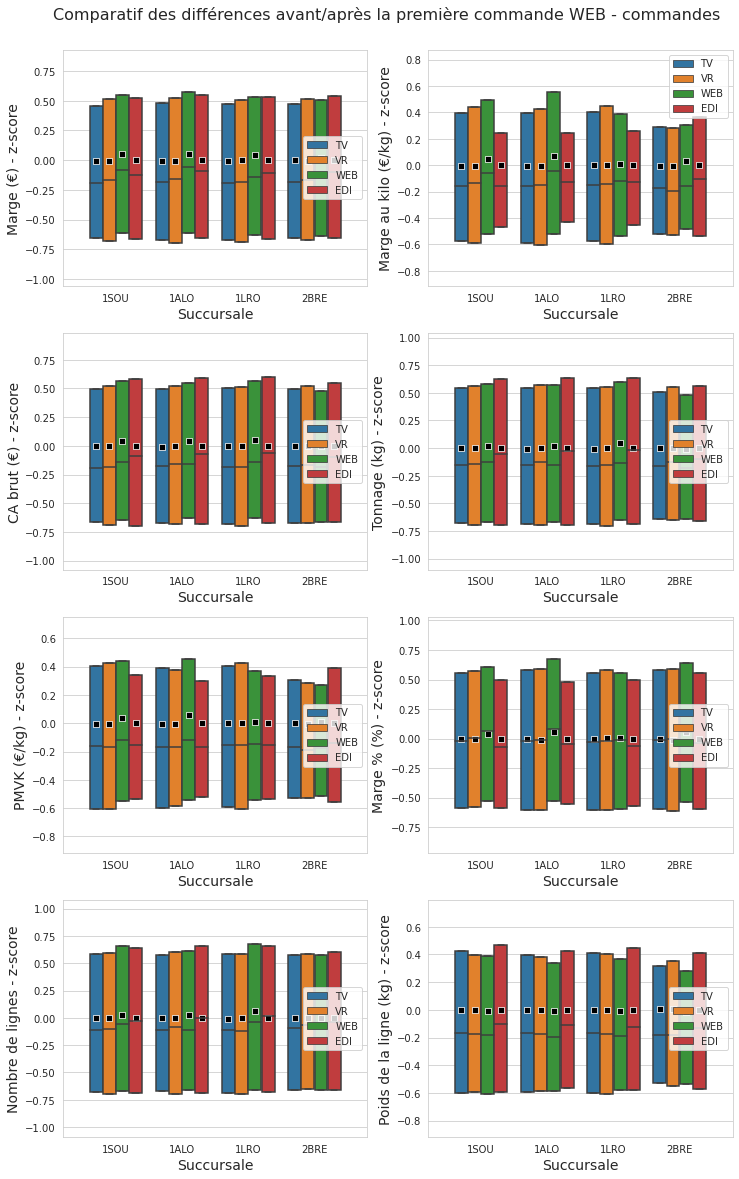

In [97]:
fig, axs = utils.plot_distrib(data=orders.reset_index(),
                              indicators=indicators_zscore,
                              filter=None,
                              ncols=2,
                              x='orgacom',
                              order=['1SOU', '1ALO', '1LRO', '2BRE'],
                              hue='clt_stat',
                              hue_order= ['TV', 'VR', 'WEB', 'EDI'],
                              translate=['xaxis', 'indicator',],
                              kind='boxplot',
                              percentile_selection=.99,
                              IQR_factor_selection=3.,
                              IQR_factor_plot=.3,
                              show_means=True,
                              plot_kwargs=dict(),
                              fontsizes_kwargs=dict(x=10),
                             )

fig.set_size_inches(12, 20)
fig.suptitle("Comparatif des différences avant/après la première commande WEB - commandes", fontsize=16, y=.91)

utils.pretty_means(data=orders.reset_index(),
                   groupers=['orgacom', 'clt_stat',],
                   indicators=indicators_zscore,
                   translate=['columns', 'clt_stat']
                  )

## Plot des détails

In [98]:
colors = {'TV': 'blue', 'VR': 'orange', 'WEB': 'green'}
sample_clt = (
# '0000210861'
# '0000020511'
'0000020697'
)
to_plot = orders.loc[idx[:, sample_clt, :]].copy()
to_plot['color'] = to_plot['origin2'].map(colors)
to_plot

margin  brutrevenue   weight  linecount origin2 seg1 seg2  \
orgacom date                                                                    
1ALO    2017-07-05   40.75       277.96   74.280          8      VR   Z3   Z4   
        2017-07-07   21.78       118.19   44.674          5      TV   Z3   Z4   
        2017-07-21   37.21       160.24   71.890          8      VR   Z3   Z4   
        2017-07-28  112.07       458.09   63.622          3      VR   Z3   Z4   
        2017-08-02   59.98       228.31   57.690          7      TV   Z3   Z4   
...                    ...          ...      ...        ...     ...  ...  ...   
        2020-08-10   26.55       122.59   20.400          4      TV   Z3   Z4   
        2020-08-14   95.33       325.25  116.594         15     WEB   Z3   Z4   
        2020-08-21   67.03       294.03   60.499         12      VR   Z3   Z4   
        2020-08-24    9.78        57.08    8.430          6     WEB   Z3   Z4   
        2020-08-28  209.28       712.54  292.463         22     WEB   Z3   Z4   

                   seg3 seg4 cat  ... margin_clt_zscore  \
orgacom date                      ...                     
1ALO    2017-07-05   ZI   ZD  ZP  ...         -0.501258   
        2017-07-07   ZI   ZD  ZP  ...         -0.949642   
        2017-07-21   ZI   ZD  ZP  ...         -0.584931   
        2017-07-28   ZI   ZD  ZP  ...          1.184493   
        2017-08-02   ZI   ZD  ZP  ...         -0.046730   
...                 ...  ...  ..  ...               ...   
        2020-08-10   ZI   ZD  ZP  ...         -0.836896   
        2020-08-14   ZI   ZD  ZP  ...          0.788819   
        2020-08-21   ZI   ZD  ZP  ...          0.119907   
        2020-08-24   ZI   ZD  ZP  ...         -1.233279   
        2020-08-28   ZI   ZD  ZP  ...          3.482192   

                   brutrevenue_clt_zscore  PMVK_clt_zscore  \
orgacom date                                                 
1ALO    2017-07-05               0.125732        -0.386247   
        2017-07-07              -0.808261        -0.794441   
        2017-07-21              -0.562443        -0.949555   
        2017-07-28               1.178747         0.901171   
        2017-08-02              -0.164515        -0.306029   
...                                   ...              ...   
        2020-08-10              -0.782539         0.457825   
        2020-08-14               0.402183        -0.740837   
        2020-08-21               0.219675         0.029979   
        2020-08-24              -1.165501         0.741412   
        2020-08-28               2.666226        -0.872349   

                    linecount_clt_zscore  marginperkg_clt_zscore  \
orgacom date                                                       
1ALO    2017-07-05              0.204194               -0.708051   
        2017-07-07             -0.436232               -0.775405   
        2017-07-21              0.204194               -0.742246   
        2017-07-28             -0.863182                0.629699   
        2017-08-02             -0.009282               -0.166404   
...                                  ...                     ...   
        2020-08-10             -0.649707                0.122318   
        2020-08-14              1.698520               -0.411335   
        2020-08-21              1.058095               -0.091121   
        2020-08-24             -0.222757               -0.033558   
        2020-08-28              3.192847               -0.523885   

                    weight_clt_zscore  marginpercent_clt_zscore  \
orgacom date                                                      
1ALO    2017-07-05           0.297741                 -1.165864   
        2017-07-07          -0.420514                 -0.723291   
        2017-07-21           0.239759                 -0.160209   
        2017-07-28           0.039173                 -0.014171   
        2017-08-02          -0.104740                  0.198057   
...                               ...

In [99]:
status_plot = status_updates.loc[idx[: , sample_clt, :]]
status_plot

new_stat     margin  brutrevenue     weight  linecount  \
orgacom date                                                                
1ALO    2017-07-05       VR  58.903706   245.856084  59.780706   6.223776   
        2019-11-29      WEB  72.606341   293.409024  69.773220   9.902439   

                    ordercount      PMVK  marginperkg  marginpercent  \
orgacom date                                                           
1ALO    2017-07-05         143  4.112633     0.985330       0.239586   
        2019-11-29          41  4.205181     1.040605       0.247458   

                    lineweight  margin_clt_zscore  brutrevenue_clt_zscore  \
orgacom date                                                                
1ALO    2017-07-05    9.605215          -0.707107               -0.707107   
        2019-11-29    7.046064           0.707107                0.707107   

                    PMVK_clt_zscore  linecount_clt_zscore  \
orgacom date                                                
1ALO    2017-07-05        -0.707107             -0.707107   
        2019-11-29         0.707107              0.707107   

                    marginperkg_clt_zscore  weight_clt_zscore  \
orgacom date                                                    
1ALO    2017-07-05               -0.707107          -0.707107   
        2019-11-29                0.707107           0.707107   

                    marginpercent_clt_zscore  lineweight_clt_zscore  
orgacom date                                                         
1ALO    2017-07-05                 -0.707107               0.707107  
        2019-11-29                  0.707107              -0.707107

In [100]:
ind_ = 'brutrevenue'

p = figure(x_axis_type="datetime", title='Détail pour ' + sample_clt + " - " + ind_, plot_height=500, plot_width=800)
first_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[0],
#                           bottom=0.,
                          right=status_plot.index.get_level_values('date')[1],
                          fill_color='blue',
                          fill_alpha=.2,
                         )
p.add_layout(first_box)
second_box = BoxAnnotation(left=status_plot.index.get_level_values('date')[1],
#                            bottom=0.,
#                            right=status_plot.index.get_level_values(2)[1],
                           fill_color='green',
                           fill_alpha=.2,
                          )

p.add_layout(second_box)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[0]) * 1000,
      y=(status_plot[ind_]).iloc[0],
      angle=0.,
      length=(datetime.timestamp(status_plot.index.get_level_values('date')[1]) - datetime.timestamp(status_plot.index.get_level_values('date')[0])) * 1000,
      line_color='blue',
      line_width=2)
p.ray(x=datetime.timestamp(status_plot.index.get_level_values('date')[1]) * 1000,
      y=(status_plot[ind_]).iloc[1],
      angle=0.,
      length=0,
      line_color='green',
      line_width=2)
p.circle(to_plot.index.get_level_values('date'), to_plot[ind_], color=to_plot.color)
show(p)

In [101]:
orders = orders.sort_index()

In [102]:
orders.loc[('1SOU', '0000065940'), ['margin', 'brutrevenue']]

margin  brutrevenue
date                           
2017-07-03   31.16        84.01
2017-08-28   44.36       105.93
2017-09-08   17.60        40.35
2017-09-15  100.12       236.77
2017-09-25   96.04       253.99
...            ...          ...
2020-03-09  295.92       715.88
2020-03-13   95.43       240.60
2020-06-05   23.07        81.50
2020-06-26  137.51       334.39
2020-08-28   42.93       114.70

[86 rows x 2 columns]

Pour le calcul d'une rentabilité par unité de temps, bien penser à resampler le datetime index AVANT de faire le rolling (cf. ci dessous)

<AxesSubplot:xlabel='date'>

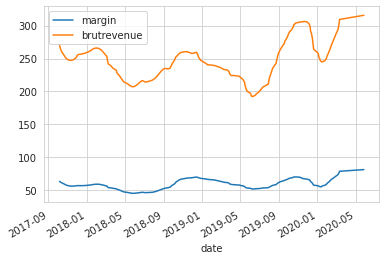

In [103]:
    (orders.loc[('1ALO', '0000020697'), ['margin', 'brutrevenue']]
          .rolling(30, win_type='triang', center=True)     
          .mean()
    ).plot(kind='line')


In [104]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17   11.01        20.82    2.350          2   
                   2017-11-06   12.23        27.83    1.450          1   
                   2017-11-20   13.92        26.43    2.850          3   
                   2018-10-01   58.89       117.10    2.200          4   
                   2019-11-18   80.70       169.10   10.400          6   
...                               ...          ...      ...        ...   
2BRE    SL009N     2020-06-23  265.71      1030.32  251.844          6   
                   2020-07-28   25.75       249.60   68.505          3   
                   2020-08-27   61.10       629.91  103.950          1   
                   2020-08-31   10.51        75.03   40.500          1   
        SLD008B    2018-09-14    3.82        70.05    4.400          1   

                              origin2 seg1 seg2 seg3 seg4 cat  ...  \
orgacom client     date                                        ...   
1SOU    0000010078 2017-07-17      TV   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-06     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-20     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2018-10-01     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2019-11-18     WEB   Z4   Z7   ZM   ZK  Z1  ...   
...                               ...  ...  ...  ...  ...  ..  ...   
2BRE    SL009N     2020-06-23      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-07-28      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-27      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-31      TV   Z4   Z9   ZO   ZM  Z3  ...   
        SLD008B    2018-09-14      TV   Z4   Z9   ZO   ZM  Z3  ...   

                               lineweight margin_clt_zscore  \
orgacom client     date                                       
1SOU    0000010078 2017-07-17    1.175000         -0.821021   
                   2017-11-06    1.450000         -0.775948   
                   2017-11-20    0.950000         -0.713512   
                   2018-10-01    0.550000          0.947901   
                   2019-11-18    1.733333          1.753669   
...                                   ...               ...   
2BRE    SL009N     2020-06-23   41.974000          1.092239   
                   2020-07-28   22.835000         -0.553079   
                   2020-08-27  103.950000         -0.310697   
                   2020-08-31   40.500000         -0.657574   
        SLD008B    2018-09-14    4.400000          0.000000   

                               brutrevenue_clt_zscore  PMVK_clt_zscore  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17               -0.840502        -0.651716   
                   2017-11-06               -0.714772         0.012193   
                   2017-11-20               -0.739882        -0.625110   
                   2018-10-01                0.886367         2.198822   
                   2019-11-18                1.819034        -0.176278   
...                                               ...              ...   
2BRE    SL009N     2020-06-23                2.809615        -0.078710   
                   2020-07-28               -0.207382        -0.160908   
                   2020-08-27                1.262280         0.282831   
                   2020-08-31               -0.881986        -0.489814   
        SLD008B    2018-09-14                0.000000         0.000000   

                               linecount_clt_zscore  marginperkg_clt_zscore  \
orgacom client     date                                                       
1SOU    0000010078 2017-07-17             -0.511372               -0.595015   
                   2017-11-06             -1.107972               -0.117863   
                   2017-11-20              0.085229       

In [105]:
orders.loc[('1SOU', '0000065940')]

margin  brutrevenue   weight  linecount origin2 seg1 seg2 seg3  \
date                                                                         
2017-07-03   31.16        84.01    5.501          9      TV   Z3   Z4   ZI   
2017-08-28   44.36       105.93    8.048         10      TV   Z3   Z4   ZI   
2017-09-08   17.60        40.35    3.000          2      TV   Z3   Z4   ZI   
2017-09-15  100.12       236.77   20.312          3      TV   Z3   Z4   ZI   
2017-09-25   96.04       253.99   40.338          5      TV   Z3   Z4   ZI   
...            ...          ...      ...        ...     ...  ...  ...  ...   
2020-03-09  295.92       715.88  102.468          6      VR   Z3   Z4   ZI   
2020-03-13   95.43       240.60   45.000          3      TV   Z3   Z4   ZI   
2020-06-05   23.07        81.50    5.400          1      VR   Z3   Z4   ZI   
2020-06-26  137.51       334.39   17.036          6      TV   Z3   Z4   ZI   
2020-08-28   42.93       114.70   16.050          2      VR   Z3   Z4   ZI   

           seg4 cat  ... lineweight margin_clt_zscore  brutrevenue_clt_zscore  \
date                 ...                                                        
2017-07-03   ZB  ZL  ...   0.611222         -0.515855               -0.420589   
2017-08-28   ZB  ZL  ...   0.804800         -0.423595               -0.376466   
2017-09-08   ZB  ZL  ...   1.500000         -0.610631               -0.508474   
2017-09-15   ZB  ZL  ...   6.770667         -0.033868               -0.113095   
2017-09-25   ZB  ZL  ...   8.067600         -0.062385               -0.078432   
...         ...  ..  ...        ...               ...                     ...   
2020-03-09   ZB  ZL  ...  17.078000          1.334650                0.851320   
2020-03-13   ZB  ZL  ...  15.000000         -0.066648               -0.105385   
2020-06-05   ZB  ZL  ...   5.400000         -0.572399               -0.425642   
2020-06-26   ZB  ZL  ...   2.839333          0.227464                0.083408   
2020-08-28   ZB  ZL  ...   8.025000         -0.433590               -0.358813   

            PMVK_clt_zscore  linecount_clt_zscore  marginperkg_clt_zscore  \
date                                                                        
2017-07-03         0.842437              2.795673                0.466740   
2017-08-28         0.423512              3.252761                0.405407   
2017-09-08         0.480651             -0.403938                0.548080   
2017-09-15         0.124511              0.053150                0.171000   
2017-09-25        -0.939954              0.967324               -0.853875   
...                     ...                   ...                     ...   
2020-03-09        -0.802960              1.424412               -0.649946   
2020-03-13        -1.128590              0.053150               -0.958531   
2020-06-05         0.806854             -0.861025               -0.093193   
2020-06-26         1.707627              1.424412                1.434939   
2020-08-28        -0.771178             -0.403938               -0.735677   

            weight_clt_zscore  marginpercent_clt_zscore  \
date                                                      
2017-07-03          -0.530799                 -0.278684   
2017-08-28          -0.480297                  0.158020   
2017-09-08          -0.580390                  0.316941   
2017-09-15          -0.237125                  0.195346   
2017-09-25           0.159954                 -0.212831   
...                       ...                       ...   
2020-03-09           1.391877                  0.108731   
2020-03-13           0.252393                 -0.043946   
2020-06-05          -0.532802                 -1.080216   
2020-06-26          -0.302082                  0.089213   
2020-08-28          -0.321632                 -0.247910   

            lineweight_clt_zscore  clt_stat  
date                                         
2017-07-03              -0.939472        TV  
2017-08-28              -0.922003  

In [106]:
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17   11.01        20.82    2.350          2   
                   2017-11-06   12.23        27.83    1.450          1   
                   2017-11-20   13.92        26.43    2.850          3   
                   2018-10-01   58.89       117.10    2.200          4   
                   2019-11-18   80.70       169.10   10.400          6   
...                               ...          ...      ...        ...   
2BRE    SL009N     2020-06-23  265.71      1030.32  251.844          6   
                   2020-07-28   25.75       249.60   68.505          3   
                   2020-08-27   61.10       629.91  103.950          1   
                   2020-08-31   10.51        75.03   40.500          1   
        SLD008B    2018-09-14    3.82        70.05    4.400          1   

                              origin2 seg1 seg2 seg3 seg4 cat  ...  \
orgacom client     date                                        ...   
1SOU    0000010078 2017-07-17      TV   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-06     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-20     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2018-10-01     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2019-11-18     WEB   Z4   Z7   ZM   ZK  Z1  ...   
...                               ...  ...  ...  ...  ...  ..  ...   
2BRE    SL009N     2020-06-23      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-07-28      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-27      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-31      TV   Z4   Z9   ZO   ZM  Z3  ...   
        SLD008B    2018-09-14      TV   Z4   Z9   ZO   ZM  Z3  ...   

                               lineweight margin_clt_zscore  \
orgacom client     date                                       
1SOU    0000010078 2017-07-17    1.175000         -0.821021   
                   2017-11-06    1.450000         -0.775948   
                   2017-11-20    0.950000         -0.713512   
                   2018-10-01    0.550000          0.947901   
                   2019-11-18    1.733333          1.753669   
...                                   ...               ...   
2BRE    SL009N     2020-06-23   41.974000          1.092239   
                   2020-07-28   22.835000         -0.553079   
                   2020-08-27  103.950000         -0.310697   
                   2020-08-31   40.500000         -0.657574   
        SLD008B    2018-09-14    4.400000          0.000000   

                               brutrevenue_clt_zscore  PMVK_clt_zscore  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17               -0.840502        -0.651716   
                   2017-11-06               -0.714772         0.012193   
                   2017-11-20               -0.739882        -0.625110   
                   2018-10-01                0.886367         2.198822   
                   2019-11-18                1.819034        -0.176278   
...                                               ...              ...   
2BRE    SL009N     2020-06-23                2.809615        -0.078710   
                   2020-07-28               -0.207382        -0.160908   
                   2020-08-27                1.262280         0.282831   
                   2020-08-31               -0.881986        -0.489814   
        SLD008B    2018-09-14                0.000000         0.000000   

                               linecount_clt_zscore  marginperkg_clt_zscore  \
orgacom client     date                                                       
1SOU    0000010078 2017-07-17             -0.511372               -0.595015   
                   2017-11-06             -1.107972               -0.117863   
                   2017-11-20              0.085229       

In [107]:
orders.loc[('1SOU', '0000010078')]

margin  brutrevenue  weight  linecount origin2 seg1 seg2 seg3  \
date                                                                        
2017-07-17   11.01        20.82    2.35          2      TV   Z4   Z7   ZM   
2017-11-06   12.23        27.83    1.45          1     WEB   Z4   Z7   ZM   
2017-11-20   13.92        26.43    2.85          3     WEB   Z4   Z7   ZM   
2018-10-01   58.89       117.10    2.20          4     WEB   Z4   Z7   ZM   
2019-11-18   80.70       169.10   10.40          6     WEB   Z4   Z7   ZM   
2020-03-13   20.18        46.87    4.20          2     WEB   Z4   Z7   ZM   
2020-08-25   35.70        65.62    4.36          2     WEB   Z4   Z7   ZM   

           seg4 cat  ... lineweight margin_clt_zscore  brutrevenue_clt_zscore  \
date                 ...                                                        
2017-07-17   ZK  Z1  ...   1.175000         -0.821021               -0.840502   
2017-11-06   ZK  Z1  ...   1.450000         -0.775948               -0.714772   
2017-11-20   ZK  Z1  ...   0.950000         -0.713512               -0.739882   
2018-10-01   ZK  Z1  ...   0.550000          0.947901                0.886367   
2019-11-18   ZK  Z1  ...   1.733333          1.753669                1.819034   
2020-03-13   ZK  Z1  ...   2.100000         -0.482236               -0.373272   
2020-08-25   ZK  Z1  ...   2.180000          0.091148               -0.036974   

            PMVK_clt_zscore  linecount_clt_zscore  marginperkg_clt_zscore  \
date                                                                        
2017-07-17        -0.651716             -0.511372               -0.595015   
2017-11-06         0.012193             -1.107972               -0.117863   
2017-11-20        -0.625110              0.085229               -0.569676   
2018-10-01         2.198822              0.681829                2.215311   
2019-11-18        -0.176278              1.875030               -0.203748   
2020-03-13        -0.503949             -0.511372               -0.579787   
2020-08-25        -0.253964             -0.511372               -0.149222   

            weight_clt_zscore  marginpercent_clt_zscore  \
date                                                      
2017-07-17          -0.536442                  0.800646   
2017-11-06          -0.833940                 -1.186423   
2017-11-20          -0.371165                  0.752969   
2018-10-01          -0.586025                  0.224414   
2019-11-18           2.124517                 -0.346397   
2020-03-13           0.075083                 -1.384347   
2020-08-25           0.127972                  1.139138   

            lineweight_clt_zscore  clt_stat  
date                                         
2017-07-17              -0.454370        TV  
2017-11-06               0.002771       WEB  
2017-11-20              -0.828395       WEB  
2018-10-01              -1.493327       WEB  
2019-11-18               0.473764       WEB  
2020-03-13               1.083285       WEB  
2020-08-25               1.216272       WEB  

[7 rows x 25 columns]

In [108]:
%%time
day_orders = (
orders[['weight', 'margin', 'brutrevenue', 'origin2']].rename_axis('indicators', axis=1)
    .reset_index().astype({'orgacom': 'object', 'origin2': 'object'})
    .set_index(['orgacom', 'client', 'date', 'origin2']).unstack('origin2', fill_value=0)
    .reset_index().set_index('date')
    .groupby(['orgacom', 'client'], observed=True, )
    .apply(lambda x: x.asfreq('B', fill_value=np.nan))
    .drop(['orgacom', 'client'], axis=1)
    .fillna(0.)
#     .unstack('origin2', fill_value=0)
#     .groupby('indicators', axis=1)
#     .sum()
)
day_orders

/var/lib/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


CPU times: user 5min 12s, sys: 2.97 s, total: 5min 15s
Wall time: 5min 15s


indicators                    weight                    margin               \
origin2                          EDI       TV   VR  WEB    EDI      TV   VR   
orgacom client     date                                                       
1ALO    0000015304 2017-07-03    0.0  190.642  0.0  0.0    0.0  202.80  0.0   
                   2017-07-04    0.0   24.200  0.0  0.0    0.0   33.70  0.0   
                   2017-07-05    0.0  112.550  0.0  0.0    0.0   86.73  0.0   
                   2017-07-06    0.0    6.200  0.0  0.0    0.0   17.55  0.0   
                   2017-07-07    0.0   27.000  0.0  0.0    0.0   13.77  0.0   
...                              ...      ...  ...  ...    ...     ...  ...   
2BRE    SL009N     2020-08-26    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-27    0.0  103.950  0.0  0.0    0.0   61.10  0.0   
                   2020-08-28    0.0    0.000  0.0  0.0    0.0    0.00  0.0   
                   2020-08-31    0.0   40.500  0.0  0.0    0.0   10.51  0.0   
        SLD008B    2018-09-14    0.0    4.400  0.0  0.0    0.0    3.82  0.0   

indicators                         brutrevenue                     
origin2                        WEB         EDI       TV   VR  WEB  
orgacom client     date                                            
1ALO    0000015304 2017-07-03  0.0         0.0  1340.95  0.0  0.0  
                   2017-07-04  0.0         0.0   196.54  0.0  0.0  
                   2017-07-05  0.0         0.0   916.78  0.0  0.0  
                   2017-07-06  0.0         0.0    73.36  0.0  0.0  
                   2017-07-07  0.0         0.0    73.17  0.0  0.0  
...                            ...         ...      ...  ...  ...  
2BRE    SL009N     2020-08-26  0.0         0.0     0.00  0.0  0.0  
                   2020-08-27  0.0         0.0   629.91  0.0  0.0  
                   2020-08-28  0.0         0.0     0.00  0.0  0.0  
                   2020-08-31  0.0         0.0    75.03  0.0  0.0  
        SLD008B    2018-09-14  0.0         0.0    70.05  0.0  0.0  

[15650027 rows x 12 columns]

origin2 seg3   brutrevenue        margin        weight  linecount  \
0       TV   ZI  1.442330e+08  4.442153e+07  4.070919e+07    3671154   
1       TV   ZL  7.684992e+07  1.125580e+07  2.172721e+07    2305588   
2       TV   ZK  1.388515e+08  3.976169e+07  2.836650e+07    4010209   
3       TV   ZJ  7.666933e+07  9.083166e+06  2.934790e+07    2339896   
4       VR   ZI  4.610324e+07  1.526107e+07  1.095509e+07     910535   
5       VR   ZK  1.144280e+08  3.256243e+07  2.217522e+07    3312206   
6      WEB   ZI  1.079351e+07  2.956760e+06  3.230339e+06     323029   
7      WEB   ZL  2.422163e+07  3.034393e+06  7.942944e+06     407879   
8      WEB   ZK  7.279213e+06  2.231899e+06  1.582764e+06     212596   
9      EDI   ZL  1.598430e+07  1.634275e+06  4.108759e+06     388128   
10     EDI   ZJ  3.808453e+08  3.556384e+07  1.257255e+08   10544049   

    ordercount      PMVK  marginperkg  marginpercent  lineweight  \
0       346049  3.543007     1.091192       0.307985   11.088935   
1       138823  3.537036     0.518051       0.146465    9.423717   
2       383141  4.894911     1.401713       0.286361    7.073572   
3       133173  2.612430     0.309500       0.118472   12.542395   
4        84063  4.208387     1.393058       0.331019   12.031482   
5       293484  5.160174     1.468415       0.284567    6.695000   
6        20520  3.341295     0.915309       0.273939   10.000151   
7        18610  3.049452     0.382024       0.125276   19.473776   
8        15833  4.599050     1.410127       0.306613    7.444940   
9        19030  3.890298     0.397754       0.102243   10.586094   
10      467454  3.029181     0.282869       0.093381   11.923833   

    lineperorder  origin2_lib     seg3_lib  brutrevenue_s   margin_s  \
0      10.608769    Télévente     Autogéré      30.770033  50.000000   
1      16.608112    Télévente    Structuré      22.460396  25.168733   
2      10.466666    Télévente  Indépendant      30.190547  47.304849   
3      17.570348    Télévente      Concédé      22.433992  22.609548   
4      10.831579  Vente route     Autogéré      17.396482  29.306617   
5      11.285815  Vente route  Indépendant      27.407021  42.808663   
6      15.742154   e-commerce     Autogéré       8.417384  12.899749   
7      21.917195   e-commerce    Structuré      12.609486  13.068002   
8      13.427398   e-commerce  Indépendant       6.912544  11.207545   
9      20.395586          EDI    Structuré      10.243361   9.590380   
10     22.556335          EDI      Concédé      50.000000  44.738103   

     weight_s  linecount_s  ordercount_s     PMVK_s  marginperkg_s  \
0   28.451461    29.503096     43.019897  41.430852      43.101867   
1   20.785493    23.380681     27.247790  41.395923      29.698306   
2   23.749871    30.835415     45.266809  48.697899      48.851181   
3   24.157216    23.553995     26.687547  35.576250      22.954914   
4   14.759316    14.693140     21.203278  45.153942      48.700128   
5   20.998695    28.023667     39.618021  50.000000      50.000000   
6    8.014610     8.751592     10.475849  40.234187      39.475672   
7   12.567506     9.834040      9.976398  38.436937      25.502968   
8    5.610047     7.099763      9.201999  47.203251      48.997584   
9    9.038861     9.592985     10.088346  43.413945      26.022724   
10  50.000000    50.000000     50.000000  38.308971      21.945133   

    marginpercent_s  lineweight_s  lineperorder_s   seg3_c origin2_c  
0         48.228948     37.730264       34.290060  #9467bd   #1f77b4  
1         33.259038     34.782120       42.903811   orange   #1f77b4  
2         46.505083     30.134522       34.059630  #e377c2   #1f77b4  
3         29.912388     40.126859       44.129187  #8c564b   #1f77b4  
4         50.000000     39.301081       34.648275  #9467bd   #ff7f0e  
5         46.359162     29.317046       35.367323  #e377c2   #ff7f0e  
6         45.485175     35.830116       41.770321  #9467bd   #2ca02c  
7         30.759377     50.000000       49.2865

In [114]:

day_orders.to_pickle(p / 'day_order.pkl')

In [ ]:
%%time
day_orders.join(
    pd.concat([day_orders.groupby('indicators', axis=1).sum()], keys=['total'], names=['origin2'], axis=1)
      .swaplevel(axis=1)
).sort_index(axis=1)

In [ ]:
fig, ax = plt.subplots()

In [4]:
orders = pd.read_pickle(persist_path / 'orders.pkl')
orders

margin  brutrevenue   weight  linecount  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17   11.01        20.82    2.350          2   
                   2017-11-06   12.23        27.83    1.450          1   
                   2017-11-20   13.92        26.43    2.850          3   
                   2018-10-01   58.89       117.10    2.200          4   
                   2019-11-18   80.70       169.10   10.400          6   
...                               ...          ...      ...        ...   
2BRE    SL009N     2020-06-23  265.71      1030.32  251.844          6   
                   2020-07-28   25.75       249.60   68.505          3   
                   2020-08-27   61.10       629.91  103.950          1   
                   2020-08-31   10.51        75.03   40.500          1   
        SLD008B    2018-09-14    3.82        70.05    4.400          1   

                              origin2 seg1 seg2 seg3 seg4 cat  ...  \
orgacom client     date                                        ...   
1SOU    0000010078 2017-07-17      TV   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-06     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2017-11-20     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2018-10-01     WEB   Z4   Z7   ZM   ZK  Z1  ...   
                   2019-11-18     WEB   Z4   Z7   ZM   ZK  Z1  ...   
...                               ...  ...  ...  ...  ...  ..  ...   
2BRE    SL009N     2020-06-23      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-07-28      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-27      TV   Z4   Z9   ZO   ZM  Z3  ...   
                   2020-08-31      TV   Z4   Z9   ZO   ZM  Z3  ...   
        SLD008B    2018-09-14      TV   Z4   Z9   ZO   ZM  Z3  ...   

                               lineweight margin_clt_zscore  \
orgacom client     date                                       
1SOU    0000010078 2017-07-17    1.175000         -0.821021   
                   2017-11-06    1.450000         -0.775948   
                   2017-11-20    0.950000         -0.713512   
                   2018-10-01    0.550000          0.947901   
                   2019-11-18    1.733333          1.753669   
...                                   ...               ...   
2BRE    SL009N     2020-06-23   41.974000          1.092239   
                   2020-07-28   22.835000         -0.553079   
                   2020-08-27  103.950000         -0.310697   
                   2020-08-31   40.500000         -0.657574   
        SLD008B    2018-09-14    4.400000          0.000000   

                               brutrevenue_clt_zscore  PMVK_clt_zscore  \
orgacom client     date                                                  
1SOU    0000010078 2017-07-17               -0.840502        -0.651716   
                   2017-11-06               -0.714772         0.012193   
                   2017-11-20               -0.739882        -0.625110   
                   2018-10-01                0.886367         2.198822   
                   2019-11-18                1.819034        -0.176278   
...                                               ...              ...   
2BRE    SL009N     2020-06-23                2.809615        -0.078710   
                   2020-07-28               -0.207382        -0.160908   
                   2020-08-27                1.262280         0.282831   
                   2020-08-31               -0.881986        -0.489814   
        SLD008B    2018-09-14                0.000000         0.000000   

                               linecount_clt_zscore  marginperkg_clt_zscore  \
orgacom client     date                                                       
1SOU    0000010078 2017-07-17             -0.511372               -0.595015   
                   2017-11-06             -1.107972               -0.117863   
                   2017-11-20              0.085229       

CPU times: user 105 ms, sys: 31.5 ms, total: 137 ms
Wall time: 140 ms


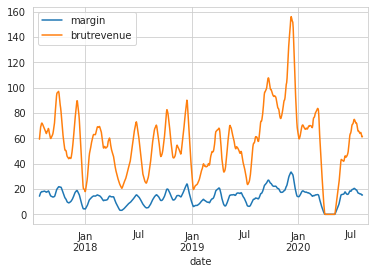

In [5]:
%%time
with pd.option_context('display.max_rows', None):
    (
    orders.loc[('1ALO', '0000020697'), ['margin', 'brutrevenue']]
          .asfreq('B', fill_value=0)
          .rolling(30, win_type='triang', center=True)
          .mean()
    ).plot(kind='line')
    

In [ ]:
status_updates

In [ ]:
status_updates

In [ ]:
status_updates['end_date'] = status_updates.reset_index().groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates.reset_index(inplace=True)

In [ ]:
status_updates

In [ ]:
status_updates.groupby(['orgacom', 'client'])['date'].shift(-1)

In [ ]:
status_updates['end_date'] = (
    status_updates.groupby(['orgacom', 'client'])['date']
                  .shift(-1, fill_value=np.nan)
)

In [ ]:
status_updates.end_date - status_updates.date

In [ ]:
for indicator in indicators2:
    status_update[indicator] = 

In [ ]:
with pd.option_context('display.max_rows', None):
    print(status_updates.head(100))

## Données de base article

In [ ]:
matfields = {'code article':'object',
              'libellé article':'category',
              'code gamme':'category',
              'libellé gamme':'category', 
              'MARC-MMSTA':'category',
              'MARC-LVORM':'category',
              'MVKE-LVORM':'category',
              'MVKE-MVSTA':'category',
              'MARA-LVORM':'category',
              'Hiérarchie produit':'object',
              'Type d\'article':'category',
              'Division':'object', 
              'Org. commerciale':'category', 
              'Canal distribution':'category',
              'File d\'achat':'category', 
              'Marque industrielle':'category', 
              'Marque commerciale':'category', 
              'Grpe de marchandises':'category', 
              'Poids net':'float', 
              'Unité de p':'category',
              'V1':'category',
              'V2':'category',
              'V3':'category',
              'LG1':'category',
              'LG2':'category',         
             }

df_mat = pd.read_csv(Path('..') / 'data' / 'Référentiel_ConverteO_1ALO_Art_20191209.csv', 
                     sep=';', 
                     header=0, 
                     encoding="ISO-8859-1", 
                     dtype=matfields,
                     decimal=",")
df_mat.sample(5)

In [ ]:
num_mat_mask = df_mat['code article'].str.isnumeric()
df_mat.loc[num_mat_mask, 'code article'] = df_mat.loc[num_mat_mask, 'code article'].str.zfill(18)
df_mat.set_index('code article', inplace=True, drop=True)
df_mat.sample(5)

In [ ]:
if sum(df_mat.index.duplicated()):
    raise RuntimeError('Something went wrong on the material dataframe! Some indices are duplicated!')

# Feature engineering et nettoyage
## Fusion des datasets
### Ajout des données articles
On ajoute dans un premier temps les données article.

In [ ]:
data2 = (
data.merge(df_mat, how='left', left_on='material', right_index=True, validate='many_to_one', indicator=True)
)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données article.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some materials are missing in material master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un code article est en double dans les master data article).

In [ ]:
if len(data2) != len(data):
    raise RuntimeError('Looks like there were duplicate material numbers in material master data!')
data = data2
del data2
data.sample(5)

### Ajout des données client
On commence par fusionner les datasets.

In [ ]:
data2 = data.merge(df_clt,
                   how='left',
                   left_on=['orgacom', 'client'],
                   right_index=True,
                   validate='many_to_one',
                   indicator=True)

On contrôle que toutes les lignes de vente ont une contrepartie dans les données client.

In [ ]:
if len(data2.loc[data2._merge != 'both']) > 0:
    print('Some clients are missing in client master data!')
data2.drop('_merge', axis=1, inplace=True)

On contrôle qu'on n'a pas dupliqué de ligne (e.g. si un couple (orgacom x client) est en double dans les master data client).

In [ ]:
if len(data2) != len(data):
    print('Looks like there were duplicate orgacom x client keys in client master data!')
data = data2
del data2
data.sample(5)